# Registrated Vehicle Forecast
# Data Science Challenge
# Delivery: Notebook
# Developer: Solano Jacon

In [5]:
# The installation of the openpyxl library would be necessary for the command pd.read_excel(file, engine='openpyxl') to work

import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
from IPython.display import Image, display
from datetime import date
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## Data Selection and Import

**Initial Considerations:**
- Last 120 months (10 years) from 2 months behind the current month (some IBGE indicators take more than 1 month to be released).
- First 84 months (7 years) will be used for model training, and last 36 months (3 years) will be used for model test.
- Model performance metrics 1: R2 or Coefficient of Determination, proportion of the variance in the dependent variable that is predictable from the independent variable, the closer to 1 => the better.
- Model performance metrics 2: MAPE (Mean Absolute Percentage Error), prediction accuracy, the closer to 0 => the better.
- Model performance metrics 3: AIC (Akaike Information Criterion), estimator of prediction error, the lower => the better, several models have AIC values around -570.

**Statistics in ANFAVEA (National Association of Motor Vehicle Manufacturers) website [https://anfavea.com.br/estatisticas](https://anfavea.com.br/estatisticas)**

- Historical Series
    - Monthly series, starting in January / 1957, of vehicles per segment (automobiles, light commercial vehicles, trucks, buses, total) of production; national, imported and total licensing; exports in units.
        - Variable: Total licensing

**SIBRA (Statistical Tables Base) in IBGE (Brazilian Institute of Geography and Statistics) website [https://sidra.ibge.gov.br](https://sidra.ibge.gov.br)**

- LSPA (Sistematic Survey on Agricultural Production)
    - Historical series of annual estimate of planted area, harvested area, production and average yield of crop products (table 6588)
        - Variable: Harvested area (Hectares)
        - Crop product: Total
        - Note: Variable Production (Tons) not available

- PIM-PF (physical industrial production index)
    - Industrial Physical Production, by sections and industrial activities (table 3653)
        - Variable: Fixed monthly base index without seasonal adjustment (Base: 2012 average = 100)
        - Sections and industrial activities: General industry

- PMC (monthly commerce survey)
    - Volume indices and nominal sales revenue in retail trade, by type of index (2014 = 100) (table 3416)
        - Variable: Retail sales volume index
        - Index type: Fixed base index (Base: 2014 = 100)

- PMS (Montlhy Services Survey)
    - Index and variation of nominal revenue and volume of services (2014 = 100) (table 6442)
        - Variable: Service volume index
        - Index type: Fixed base index (Base: 2014 = 100)

- IPCA (Broad National Consumer Price Index)
    - IPCA - Historical series with index number, monthly variation and accumulated variations in 3 months, in 6 months, in the year and in 12 months (from December / 1979) (table 1737)
        - Variable: Index number

In [6]:
# Import data directly without any treatment

anfavea_sta_raw = pd.read_excel('data/ANFAVEA_SeriesTemporais_Autoveiculos.xlsm', engine='openpyxl')
ibge_lspa_6588_raw = pd.read_excel('data/IBGE_LSPA_tabela6588.xlsx', engine='openpyxl')
ibge_pimpf_3653_raw = pd.read_excel('data/IBGE_PIMPF_tabela3653.xlsx', engine='openpyxl')
ibge_pmc_3416_raw = pd.read_excel('data/IBGE_PMC_tabela3416.xlsx', engine='openpyxl')
ibge_pms_6442_raw = pd.read_excel('data/IBGE_PMS_tabela6442.xlsx', engine='openpyxl')
ibge_ipca_1737_raw = pd.read_excel('data/IBGE_IPCA_tabela1737.xlsx', engine='openpyxl')

In [7]:
# Raw data
anfavea_sta_raw

,Unnamed: 0,Nota 1: Os dados de licenciamento até 2001 (inclusive) referem-se às vendas no atacado.,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaT,Nota 2: Os dados de produção e exportação refe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,2050317,1776860,273457,2176784,516568,1688289,1484744,203545,1798894,...,50560,48743,1817,60482,21548,11161,11154,7,18705,9765
2,NaT,AUTOVEÍCULOS TOTAL,NaN,NaN,NaN,NaN,AUTOMÓVEIS,NaN,NaN,NaN,...,CAMINHÕES,NaN,NaN,NaN,NaN,ÔNIBUS,NaN,NaN,NaN,NaN
3,NaT,Licenciamento Total,Licenciamento Nacionais,Licenciamento Importados,Produção,Exportação,Licenciamento Total,Licenciamento Nacionais,Licenciamento Importados,Produção,...,Licenciamento Total,Licenciamento Nacionais,Licenciamento Importados,Produção,Exportação,Licenciamento Total,Licenciamento Nacionais,Licenciamento Importados,Produção,Exportação
4,1957-01-01,2009,2009,0,2317,0,758,758,0,1091,...,1037,1037,0,981,0,110,110,0,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,2021-08-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
780,2021-09-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,2021-10-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Data treatment

anfavea_sta = anfavea_sta_raw.iloc[:, 0:2]
anfavea_sta.columns = ['Month', 'Registrations - Total']
anfavea_sta['Registrations - Passengers Cars'] = anfavea_sta_raw.iloc[:, 6]
anfavea_sta['Registrations - Light Commercials'] = anfavea_sta_raw.iloc[:, 11]
anfavea_sta['Registrations - Trucks'] = anfavea_sta_raw.iloc[:, 16]
anfavea_sta['Registrations - Buses'] = anfavea_sta_raw.iloc[:, 21]
anfavea_sta = anfavea_sta[4:]
anfavea_sta['Month'] = anfavea_sta['Month'].copy().astype('datetime64')
anfavea_sta[['Registrations - Total', 'Registrations - Passengers Cars', 'Registrations - Light Commercials', 'Registrations - Trucks', 'Registrations - Buses']] = \
    anfavea_sta[['Registrations - Total', 'Registrations - Passengers Cars', 'Registrations - Light Commercials', 'Registrations - Trucks', 'Registrations - Buses']].copy().astype('float64')
anfavea_sta = anfavea_sta.set_index('Month')
anfavea_sta = anfavea_sta.loc[anfavea_sta['Registrations - Total'] != 0]
anfavea_sta = anfavea_sta[-121:-1]

In [9]:
# Treated data
anfavea_sta

,Registrations - Total,Registrations - Passengers Cars,Registrations - Light Commercials,Registrations - Trucks,Registrations - Buses
Month,,,,,
2011-04-01,289189.0,231694.0,41222.0,13512.0,2761.0
2011-05-01,318534.0,253981.0,46548.0,15137.0,2868.0
2011-06-01,304333.0,242534.0,44390.0,14795.0,2614.0
2011-07-01,306231.0,242067.0,45899.0,15550.0,2715.0
2011-08-01,327610.0,258414.0,49621.0,16459.0,3116.0
...,...,...,...,...,...
2020-11-01,225010.0,177577.0,36909.0,9143.0,1381.0
2020-12-01,243967.0,194681.0,38303.0,9838.0,1145.0
2021-01-01,171146.0,130804.0,31776.0,7537.0,1029.0


In [10]:
anfavea_sta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Registrations - Total              120 non-null    float64
 1   Registrations - Passengers Cars    120 non-null    float64
 2   Registrations - Light Commercials  120 non-null    float64
 3   Registrations - Trucks             120 non-null    float64
 4   Registrations - Buses              120 non-null    float64
dtypes: float64(5)
memory usage: 5.6 KB


In [11]:
meses = {'janeiro': 1, 'fevereiro': 2, 'março': 3, 'abril': 4, 'maio': 5, 'junho': 6,
         'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12}

In [12]:
ibge_lspa_6588_raw

,"Tabela 6588 - Série histórica da estimativa anual da área plantada, área colhida, produção e rendimento médio dos produtos das lavouras",Unnamed: 1
0,Mês,Produto das lavouras x Variável
1,NaN,Brasil
2,NaN,Total
3,NaN,Área colhida (Hectares)
4,setembro 2006,60239032
...,...,...
176,janeiro 2021,81376357
177,fevereiro 2021,81531295
178,março 2021,82318878
179,abril 2021,82367560


In [13]:
ibge_lspa_6588 = ibge_lspa_6588_raw[ibge_lspa_6588_raw.columns[0:2]]
ibge_lspa_6588.columns = ['Month', 'Agriculture']
ibge_lspa_6588 = ibge_lspa_6588[4:-1]
ibge_lspa_6588['Month'] = ibge_lspa_6588['Month'].apply(lambda x: date(int(x[(x.find(' ') + 1):]), meses[x[:x.find(' ')]], 1))
ibge_lspa_6588['Month'] = ibge_lspa_6588['Month'].copy().astype('datetime64')
ibge_lspa_6588['Agriculture'] = ibge_lspa_6588['Agriculture'].copy().astype('float64')
ibge_lspa_6588 = ibge_lspa_6588.set_index('Month')
ibge_lspa_6588 = ibge_lspa_6588[-121:-1]
ibge_lspa_6588

,Agriculture
Month,
2011-04-01,65163204.0
2011-05-01,65513320.0
2011-06-01,65665703.0
2011-07-01,65532580.0
2011-08-01,65544826.0
...,...
2020-11-01,80154907.0
2020-12-01,80241907.0
2021-01-01,81376357.0


In [14]:
ibge_lspa_6588.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Agriculture  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [15]:
ibge_pimpf_3653_raw

,"Tabela 3653 - Produção Física Industrial, por seções e atividades industriais",Unnamed: 1
0,Mês,Seções e atividades industriais (CNAE 2.0) x V...
1,NaN,Brasil
2,NaN,1 Indústria geral
3,NaN,Índice de base fixa sem ajuste sazonal (Base: ...
4,janeiro 2002,72.4
...,...,...
231,dezembro 2020,83.3
232,janeiro 2021,81.9
233,fevereiro 2021,79.1
234,março 2021,86.0


In [16]:
ibge_pimpf_3653 = ibge_pimpf_3653_raw[ibge_pimpf_3653_raw.columns[0:2]]
ibge_pimpf_3653.columns = ['Month', 'Industry']
ibge_pimpf_3653 = ibge_pimpf_3653[4:-1]
ibge_pimpf_3653['Month'] = ibge_pimpf_3653['Month'].apply(lambda x: date(int(x[(x.find(' ') + 1):]), meses[x[:x.find(' ')]], 1))
ibge_pimpf_3653['Month'] = ibge_pimpf_3653['Month'].copy().astype('datetime64')
ibge_pimpf_3653['Industry'] = ibge_pimpf_3653['Industry'].copy().astype('float64')
ibge_pimpf_3653 = ibge_pimpf_3653.set_index('Month')
ibge_pimpf_3653 = ibge_pimpf_3653[-120:]
ibge_pimpf_3653

,Industry
Month,
2011-04-01,97.5
2011-05-01,107.1
2011-06-01,102.8
2011-07-01,106.1
2011-08-01,110.8
...,...
2020-11-01,90.2
2020-12-01,83.3
2021-01-01,81.9


In [17]:
ibge_pimpf_3653.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Industry  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [18]:
ibge_pmc_3416_raw

,"Tabela 3416 - Índices de volume e de receita nominal de vendas no comércio varejista, por tipos de índice (2014 = 100)",Unnamed: 1
0,Mês,Tipos de índice x Variável
1,NaN,Brasil
2,NaN,Índice base fixa (2014=100)
3,NaN,Índice de volume de vendas no comércio varejis...
4,janeiro 2000,46.0
...,...,...
255,dezembro 2020,125.1
256,janeiro 2021,93.6
257,fevereiro 2021,86.1
258,março 2021,91.4


In [19]:
ibge_pmc_3416 = ibge_pmc_3416_raw[ibge_pmc_3416_raw.columns[0:2]]
ibge_pmc_3416.columns = ['Month', 'Commerce']
ibge_pmc_3416 = ibge_pmc_3416[4:-1]
ibge_pmc_3416['Month'] = ibge_pmc_3416['Month'].apply(lambda x: date(int(x[(x.find(' ') + 1):]), meses[x[:x.find(' ')]], 1))
ibge_pmc_3416['Month'] = ibge_pmc_3416['Month'].copy().astype('datetime64')
ibge_pmc_3416['Commerce'] = ibge_pmc_3416['Commerce'].copy().astype('float64')
ibge_pmc_3416 = ibge_pmc_3416.set_index('Month')
ibge_pmc_3416 = ibge_pmc_3416[-120:]
ibge_pmc_3416

,Commerce
Month,
2011-04-01,82.9
2011-05-01,84.8
2011-06-01,82.5
2011-07-01,85.3
2011-08-01,85.7
...,...
2020-11-01,108.6
2020-12-01,125.1
2021-01-01,93.6


In [20]:
ibge_pmc_3416.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Commerce  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [21]:
ibge_pms_6442_raw

,Tabela 6442 - Índice e variação da receita nominal e do volume de serviços (2014 = 100),Unnamed: 1
0,Mês,Tipos de índice x Variável
1,NaN,Brasil
2,NaN,Índice base fixa (2014=100)
3,NaN,Índice de volume de serviços (Número-índice)
4,janeiro 2011,83.8
...,...,...
123,dezembro 2020,95.6
124,janeiro 2021,83.6
125,fevereiro 2021,82.6
126,março 2021,87.9


In [22]:
ibge_pms_6442 = ibge_pms_6442_raw[ibge_pms_6442_raw.columns[0:2]]
ibge_pms_6442.columns = ['Month', 'Services']
ibge_pms_6442 = ibge_pms_6442[4:-1]
ibge_pms_6442['Month'] = ibge_pms_6442['Month'].apply(lambda x: date(int(x[(x.find(' ') + 1):]), meses[x[:x.find(' ')]], 1))
ibge_pms_6442['Month'] = ibge_pms_6442['Month'].copy().astype('datetime64')
ibge_pms_6442['Services'] = ibge_pms_6442['Services'].copy().astype('float64')
ibge_pms_6442 = ibge_pms_6442.set_index('Month')
ibge_pms_6442 = ibge_pms_6442[-120:]
ibge_pms_6442

,Services
Month,
2011-04-01,86.7
2011-05-01,89.8
2011-06-01,89.0
2011-07-01,90.7
2011-08-01,92.8
...,...
2020-11-01,88.0
2020-12-01,95.6
2021-01-01,83.6


In [23]:
ibge_pms_6442.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Services  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [24]:
ibge_ipca_1737_raw

,"Tabela 1737 - IPCA - Série histórica com número-índice, variação mensal e variações acumuladas em 3 meses, em 6 meses, no ano e em 12 meses (a partir de dezembro/1979)",Unnamed: 1
0,Mês,Variável
1,NaN,Brasil
2,NaN,IPCA - Número-índice (base: dezembro de 1993 =...
3,dezembro 1979,0.0
4,janeiro 1980,0.0
...,...,...
496,janeiro 2021,5574.49
497,fevereiro 2021,5622.43
498,março 2021,5674.72
499,abril 2021,5692.31


In [25]:
ibge_ipca_1737 = ibge_ipca_1737_raw[ibge_ipca_1737_raw.columns[0:2]]
ibge_ipca_1737.columns = ['Month', 'Inflation']
ibge_ipca_1737 = ibge_ipca_1737[4:-1]
ibge_ipca_1737['Month'] = ibge_ipca_1737['Month'].apply(lambda x: date(int(x[(x.find(' ') + 1):]), meses[x[:x.find(' ')]], 1))
ibge_ipca_1737['Month'] = ibge_ipca_1737['Month'].copy().astype('datetime64')
ibge_ipca_1737['Inflation'] = ibge_ipca_1737['Inflation'].copy().astype('float64')
ibge_ipca_1737 = ibge_ipca_1737.set_index('Month')
ibge_ipca_1737 = ibge_ipca_1737[-121:-1]
ibge_ipca_1737

,Inflation
Month,
2011-04-01,3299.07
2011-05-01,3314.58
2011-06-01,3319.55
2011-07-01,3324.86
2011-08-01,3337.16
...,...
2020-11-01,5486.52
2020-12-01,5560.59
2021-01-01,5574.49


In [26]:
ibge_ipca_1737.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Feature Engineering

In [27]:
def rfwd_calc(row, column):
    last_day = calendar.monthrange(row['Month'].year, row['Month'].month)[1]
    start = date(row['Month'].year, row['Month'].month, 1)
    end = date(row['Month'].year, row['Month'].month, last_day)
    bus_days = np.busday_count(start, end)
    rfwd = row[column] / bus_days
    return rfwd

In [28]:
# Calculate registrations for working day or RTFWD (monthly tot. / nr. of working days)

anfavea_sta = anfavea_sta.reset_index()
anfavea_sta['RTFWD'] = anfavea_sta.apply(lambda row: rfwd_calc(row, 'Registrations - Total'), axis=1)
anfavea_sta['RPCFWD'] = anfavea_sta.apply(lambda row: rfwd_calc(row, 'Registrations - Passengers Cars'), axis=1)
anfavea_sta['RLCFWD'] = anfavea_sta.apply(lambda row: rfwd_calc(row, 'Registrations - Light Commercials'), axis=1)
anfavea_sta['RTRFWD'] = anfavea_sta.apply(lambda row: rfwd_calc(row, 'Registrations - Trucks'), axis=1)
anfavea_sta['RBUFWD'] = anfavea_sta.apply(lambda row: rfwd_calc(row, 'Registrations - Buses'), axis=1)
anfavea_sta = anfavea_sta.set_index('Month')
anfavea_sta.head()

,Registrations - Total,Registrations - Passengers Cars,Registrations - Light Commercials,Registrations - Trucks,Registrations - Buses,RTFWD,RPCFWD,RLCFWD,RTRFWD,RBUFWD
Month,,,,,,,,,,
2011-04-01,289189.0,231694.0,41222.0,13512.0,2761.0,13770.904762,11033.047619,1962.952381,643.428571,131.476190
2011-05-01,318534.0,253981.0,46548.0,15137.0,2868.0,15168.285714,12094.333333,2216.571429,720.809524,136.571429
2011-06-01,304333.0,242534.0,44390.0,14795.0,2614.0,14492.047619,11549.238095,2113.809524,704.523810,124.476190
2011-07-01,306231.0,242067.0,45899.0,15550.0,2715.0,14582.428571,11527.000000,2185.666667,740.476190,129.285714
2011-08-01,327610.0,258414.0,49621.0,16459.0,3116.0,14891.363636,11746.090909,2255.500000,748.136364,141.636364


## Simplified Model without External Variables

In [29]:
# Training/Test split

train = anfavea_sta[['RTFWD']][:-36]
test = anfavea_sta[['RTFWD']][-36:]

In [30]:
# Calculation of the predictive value of the simplified model as the value of the previous month

y_pred = test.shift(1)
y_pred.head()

,RTFWD
Month,
2018-04-01,NaN
2018-05-01,10866.500000
2018-06-01,9177.136364
2018-07-01,9618.190476
2018-08-01,10357.571429


In [31]:
# Calculation of the proportion of the R2 variance of the predicted value by
# the value of the previous month in the simplified model

y_pred = test.shift(1).dropna()
y_true = test[1:]
print(f"Simplified Model without External Variables - R2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Simplified Model without External Variables - MAPE: {round(mean_absolute_percentage_error(y_true, y_pred), 3)}")

Simplified Model without External Variables - R2: 0.448
Simplified Model without External Variables - MAPE: 0.165


## Linear Model without External Variables

In [32]:
# Linear model with 12 auto-regressive features

anfavea_sta_svr = anfavea_sta[['RTFWD']].copy()

for i in range(1, 13):
    anfavea_sta_svr[f't - {i}'] = anfavea_sta['RTFWD'].shift(i)

anfavea_sta_svr.dropna(inplace=True)
anfavea_sta_svr.head()

,RTFWD,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Month,,,,,,,,,,,,,
2012-04-01,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714,13770.904762
2012-05-01,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714
2012-06-01,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619
2012-07-01,17342.666667,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571
2012-08-01,19094.545455,17342.666667,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636


In [33]:
# Training/Test and X/y Split

train = anfavea_sta_svr[:-36]
test = anfavea_sta_svr[-36:]

train_X = train.drop(columns = ['RTFWD'])
train_y = train['RTFWD']
test_X = test.drop(columns = ['RTFWD'])
test_y = test['RTFWD']

print(train_X.shape, train_y.shape,
      test_X.shape, test_y.shape)

(72, 12) (72,) (36, 12) (36,)


Linear Model without External Variables - R2:  0.467
Linear Model without External Variables - MAPE:  0.18


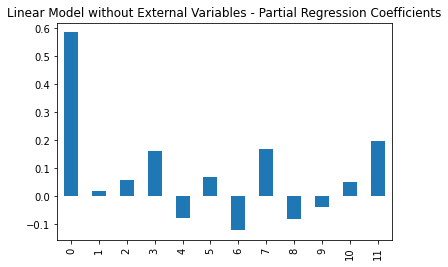

In [34]:
# Predict and measure R2

# ANALYSIS - Model Feasibility: Linear model is feasible?

# CONCLUSION - Model Feasibility: We need to train one model per forecast horizon.
#                                 Model performance drops quickly as horizon increases.
#                                 Impossibility to consider external variables.

linear_model = LinearRegression()
linear_model = linear_model.fit(train_X, train_y)

print('Linear Model without External Variables - R2: ', round(r2_score(test_y, linear_model.predict(test_X)), 3))
print('Linear Model without External Variables - MAPE: ', round(mean_absolute_percentage_error(test_y, linear_model.predict(test_X)), 3))
pd.Series(linear_model.coef_).plot(kind='bar'); plt.title('Linear Model without External Variables - Partial Regression Coefficients');

## Decomposition, Autocorrelation, Stationarity and Model Order Hyperparameters

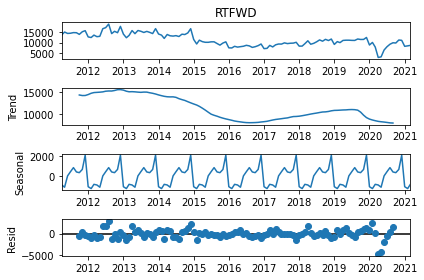

In [35]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)

result_dec_add = seasonal_decompose(anfavea_sta['RTFWD'], model='additive')
result_dec_add.plot();

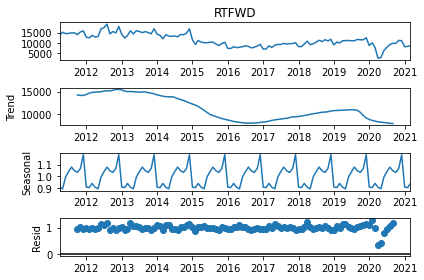

In [36]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)

result_dec_mul = seasonal_decompose(anfavea_sta['RTFWD'], model='multiplicative')
result_dec_mul.plot();

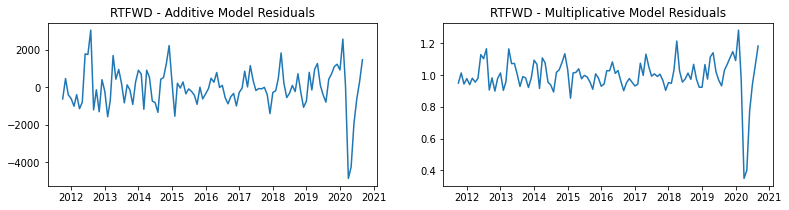

In [37]:
# Plot the residuals to decide between Additive X Multiplicative Decomposition

# ANALYSIS - Stationarity: "less notion of time" => better

# CONCLUSION - Stationarity: Additive and Multiplicative Residuals show almost the same notion of time =>
#                            both Decomposition could be used

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
ax1.plot(result_dec_add.resid); ax1.set_title("RTFWD - Additive Model Residuals")
ax2.plot(result_dec_mul.resid); ax2.set_title("RTFWD - Multiplicative Model Residuals");

In [38]:
# ADF test (p-value) on the residuals to decide between Additive X Multiplicative Decomposition

# ANALYSIS - Stationarity: ADF < 0.05 => stationary , less => better

# CONCLUSION - Stationarity: Additive and Multiplicative Residuals show almost the same result indicating stationarity =>
#                            both Decomposition could be used

print('RTFWD - ADF Test - Additive Residuals: ', adfuller(result_dec_add.resid.dropna())[1])
print('RTFWD - ADF Test - Multiplicative Residuals: ', adfuller(result_dec_mul.resid.dropna())[1])

RTFWD - ADF Test - Additive Residuals:  1.371422039011218e-07
RTFWD - ADF Test - Multiplicative Residuals:  1.8313777974805578e-05


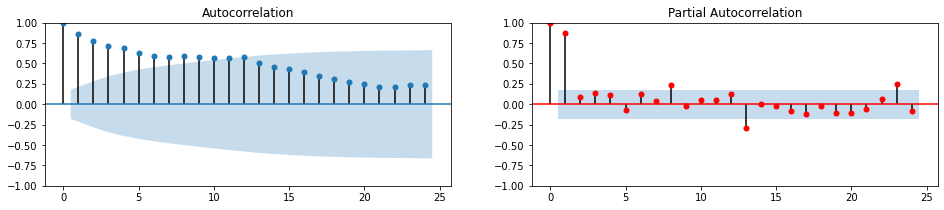

In [39]:
# Plot each correlation in an Autocorrelation Function graph (ACF) and
# each partial correlation in a Partial Autocorrelation Function (PACF) graph

# ANALYSIS - Statistical Significance: peak inside the blue area => not statistically significant

# CONCLUSION - Autocorrelation: peaks every 12 months indicate the seasonal nature of the data
#              Partial Autocorrelation: just first peak or next month is statistically significant

# NOTE - Peak at 0 should be disregarded

fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(anfavea_sta['RTFWD'], lags=24, ax=axes[0])
plot_pacf(anfavea_sta['RTFWD'], lags=24, ax=axes[1], color='r');

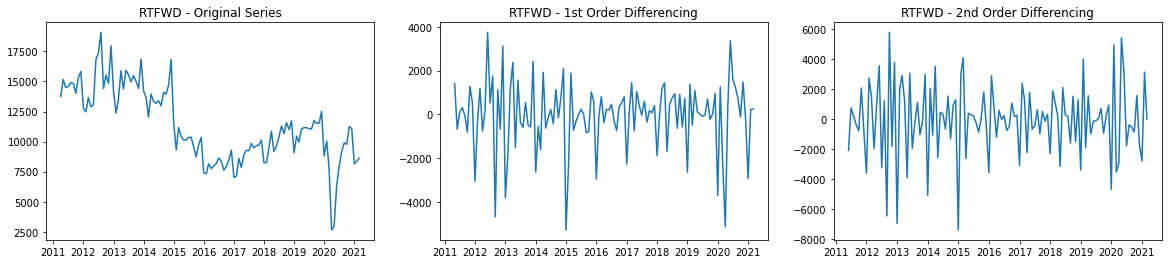

In [40]:
# Plot original series with the first differentials

# ANALYSIS - Stationary: stationary?

# CONCLUSION - Stationary: seasonality is still present => not stationary => cannot apply ARIMA model directly

zero_diff = anfavea_sta['RTFWD']
first_order_diff = anfavea_sta['RTFWD'].diff(1)
second_order_diff = anfavea_sta['RTFWD'].diff(1).diff(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('RTFWD - Original Series')
ax2.plot(first_order_diff); ax2.set_title('RTFWD - 1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('RTFWD - 2nd Order Differencing');

In [41]:
# Remove seasonality
anfavea_sta['RTFWD deseasonalized'] = anfavea_sta['RTFWD'].values / result_dec_mul.seasonal

# Apply log in deseasonalized series
anfavea_sta['RTFWD deseasonalized log'] = np.log(anfavea_sta['RTFWD deseasonalized'])

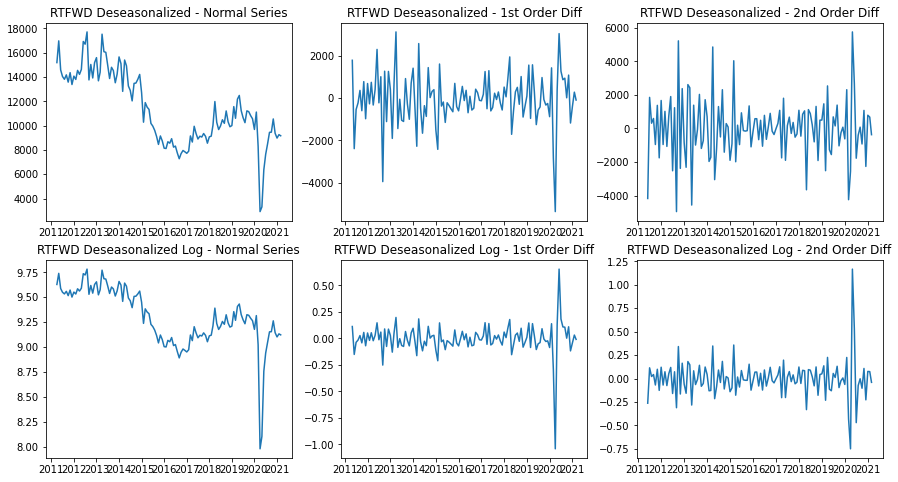

In [42]:
# Plot deseasonalized without/with log series with the first differentials
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes[0, 0].plot(anfavea_sta['RTFWD deseasonalized']); axes[0, 0].set_title('RTFWD Deseasonalized - Normal Series')
y_diff = anfavea_sta['RTFWD deseasonalized'].diff().dropna(); axes[0, 1].plot(y_diff); axes[0, 1].set_title('RTFWD Deseasonalized - 1st Order Diff')
y_diff_diff = anfavea_sta['RTFWD deseasonalized'].diff().diff().dropna(); axes[0, 2].plot(y_diff_diff); axes[0, 2].set_title('RTFWD Deseasonalized - 2nd Order Diff')
axes[1, 0].plot(anfavea_sta['RTFWD deseasonalized log']); axes[1, 0].set_title('RTFWD Deseasonalized Log - Normal Series')
y_log_diff = anfavea_sta['RTFWD deseasonalized log'].diff().dropna(); axes[1, 1].plot(y_log_diff); axes[1, 1].set_title('RTFWD Deseasonalized Log - 1st Order Diff')
y_log_diff_diff = anfavea_sta['RTFWD deseasonalized log'].diff().diff().dropna(); axes[1, 2].plot(y_log_diff_diff); axes[1, 2].set_title('RTFWD Deseasonalized Log - 2nd Order Diff');

In [43]:
# ADF test (p-value) on deseasonalized without/with log series to decide how many differentiations will be needed

# ANALYSIS - Stationarity: ADF < 0.05 => stationary , less => better

# CONCLUSION - Stationarity: 1st order diff => stationary => d term in ARIMA/SARIMAX model is 1

print('RTFWD Deseasonalized - ADF Test - Normal Series: ',
      adfuller(anfavea_sta['RTFWD deseasonalized'].dropna())[1])
print('RTFWD Deseasonalized - ADF Test - 1st Order Diff: ',
      adfuller(anfavea_sta['RTFWD deseasonalized'].diff().dropna())[1])
print('RTFWD Deseasonalized - ADF Test - 2nd Order Diff: ',
      adfuller(anfavea_sta['RTFWD deseasonalized'].diff().diff().dropna())[1])
print('RTFWD Deseasonalized Log - ADF Test - Normal Series: ',
      adfuller(anfavea_sta['RTFWD deseasonalized log'].dropna())[1])
print('RTFWD Deseasonalized Log - ADF Test - 1st Order Diff: ',
      adfuller(anfavea_sta['RTFWD deseasonalized log'].diff().dropna())[1])
print('RTFWD Deseasonalized Log - ADF Test - 2nd Order Diff: ',
      adfuller(anfavea_sta['RTFWD deseasonalized log'].diff().diff().dropna())[1])

RTFWD Deseasonalized - ADF Test - Normal Series:  0.13650501165400974
RTFWD Deseasonalized - ADF Test - 1st Order Diff:  1.5944266072076959e-16
RTFWD Deseasonalized - ADF Test - 2nd Order Diff:  1.8776748421586147e-07
RTFWD Deseasonalized Log - ADF Test - Normal Series:  0.17468449735648872
RTFWD Deseasonalized Log - ADF Test - 1st Order Diff:  3.253600456313656e-18
RTFWD Deseasonalized Log - ADF Test - 2nd Order Diff:  1.5121628259122717e-10


In [44]:
# Automatically estimate differencing term

print('RTFWD Deseasonalized - Number of Needed Differentials: ', ndiffs(anfavea_sta['RTFWD deseasonalized']))
print('RTFWD Deseasonalized Log - Number of Needed Differentials: ', ndiffs(anfavea_sta['RTFWD deseasonalized log']))

RTFWD Deseasonalized - Number of Needed Differentials:  1
RTFWD Deseasonalized Log - Number of Needed Differentials:  1


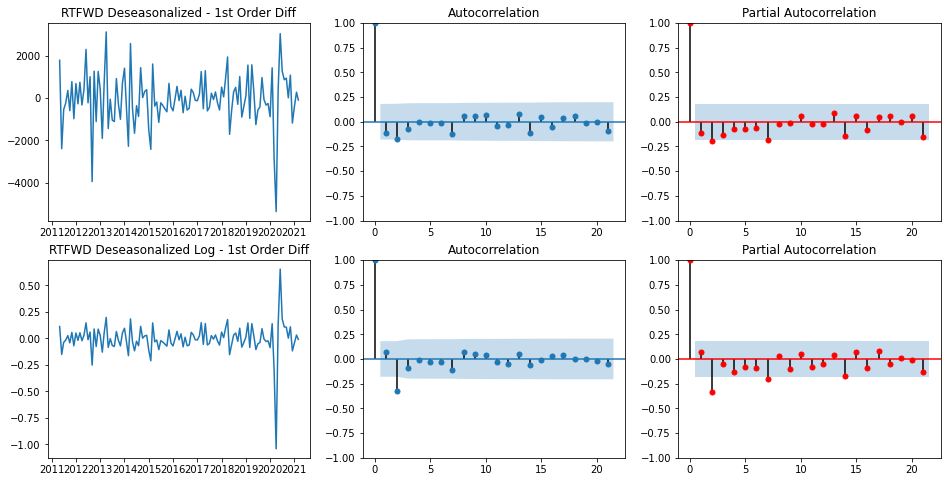

In [45]:
# ACF / PACF analysis of 1st order diff deseasonalized series
# ANALYSIS - Autocorrelation: peak outside the blue area => q term in ARIMA/SARIMAX model
#            Partial Autocorrelation: peak outside the blue area => p term in ARIMA/SARIMAX model
# CONCLUSION - Autocorrelation: q term is 0 - Partial Autocorrelation: p term is 0
# NOTE - Peak at 0 should be disregarded
fig, axes = plt.subplots(2,3, figsize=(16,8))
axes[0, 0].plot(y_diff); axes[0, 0].set_title('RTFWD Deseasonalized - 1st Order Diff'); plot_acf(y_diff, ax=axes[0, 1]); plot_pacf(y_diff, ax=axes[0, 2], c='r')
axes[1, 0].plot(y_log_diff); axes[1, 0].set_title('RTFWD Deseasonalized Log - 1st Order Diff'); plot_acf(y_log_diff, ax=axes[1, 1]); plot_pacf(y_log_diff, ax=axes[1, 2], c='r');

## ARIMA Model without External Variables

In [46]:
# Training/Test split

train = anfavea_sta[['RTFWD deseasonalized', 'RTFWD deseasonalized log']][:-36]
test = anfavea_sta[['RTFWD deseasonalized', 'RTFWD deseasonalized log']][-36:]

In [47]:
# ARIMA model without External Variables - RTFWD Deseasonalized without Log
# Search for best order hyperparameters automatically
arima_model = pm.auto_arima(train['RTFWD deseasonalized'], start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1402.931, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1404.327, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1403.094, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1401.196, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1400.056, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1399.589, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1400.728, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1402.285, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1401.510, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1399.970, Time=0.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1400.615, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1398.190, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1398.704, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

In [48]:
# ARIMA model without External Variables - RTFWD Deseasonalized with Log
# Search for best order hyperparameters automatically
arima_model_log = pm.auto_arima(train['RTFWD deseasonalized log'], start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-174.108, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-179.049, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-181.692, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-175.807, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-180.306, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-180.332, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-178.338, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-182.547, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-180.968, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-181.005, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-180.382, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-179.005, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.196 seconds


In [49]:
# ARIMA model without External Variables - RTFWD Deseasonalized without Log
# Order hyperparameters automatically chosen with manual ajust
# Build model
arima_model = ARIMA(train['RTFWD deseasonalized'], order=(0, 1, 0))
arima_model = arima_model.fit()
# Forecast
forecast_results = arima_model.get_forecast(len(test) + 6, alpha=0.05)  # 95% confidence
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
# Model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     RTFWD deseasonalized   No. Observations:                   84
Model:                   ARIMA(0, 1, 0)   Log Likelihood                -699.598
Date:                  Wed, 24 Aug 2022   AIC                           1401.196
Time:                          13:41:55   BIC                           1403.615
Sample:                      04-01-2011   HQIC                          1402.168
                           - 03-01-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.214e+06   1.37e+05      8.832      0.000    9.45e+05    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.66   Jarque-Bera (JB):                 9.94
Prob(Q):                              0.01   Prob(JB):                         0.01
Heteroskedasticity (H):               0.14   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# ARIMA model without External Variables - RTFWD Deseasonalized with Log
# Order hyperparameters automatically chosen with manual ajust
# Build model
arima_model_log = ARIMA(train['RTFWD deseasonalized log'], order=(0, 1, 0))
arima_model_log = arima_model_log.fit()
# Forecast
forecast_results = arima_model_log.get_forecast(len(test) + 6, alpha=0.05)  # 95% confidence
forecast_log = forecast_results.predicted_mean
confidence_int_log = forecast_results.conf_int().values
# Model summary
arima_model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     RTFWD deseasonalized log   No. Observations:                   84
Model:                       ARIMA(0, 1, 0)   Log Likelihood                  88.903
Date:                      Wed, 24 Aug 2022   AIC                           -175.807
Time:                              13:41:55   BIC                           -173.388
Sample:                          04-01-2011   HQIC                          -174.835
                               - 03-01-2018                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0069      0.001      7.177      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   6.69   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.01   Prob(JB):                         0.66
Heteroskedasticity (H):               0.43   Skew:                            -0.07
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
# Define plot "Forecast vs Real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None, title='Forecast vs Real'):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8);

In [52]:
# Define plot "Absolute Error"

def plot_absolute_error(absolute_error_zero, absolute_error_test, title='Absolute Error (Real - Forecast)'):
    plt.figure(figsize=(10,1), dpi=100)
    plt.plot(absolute_error_zero, color='gray', ls='--')
    plt.plot(absolute_error_test, color='orange')
    plt.title(title);

In [53]:
# Forecast seasonality based on past monthly average

result_dec_mul_seasonal_forecast = pd.DataFrame(result_dec_mul.seasonal)
result_dec_mul_seasonal_forecast = result_dec_mul_seasonal_forecast.reset_index()
result_dec_mul_seasonal_forecast['Month'] = result_dec_mul_seasonal_forecast['Month'].apply(lambda x: x.month)
result_dec_mul_seasonal_forecast = result_dec_mul_seasonal_forecast.groupby(['Month']).agg({'seasonal' : 'mean'})
result_dec_mul_seasonal_forecast = result_dec_mul_seasonal_forecast.reset_index()
result_dec_mul_seasonal_forecast = result_dec_mul_seasonal_forecast[3:9]
result_dec_mul_seasonal_forecast['Month'] = result_dec_mul_seasonal_forecast['Month'].apply(lambda x: date(2021, x, 1))
result_dec_mul_seasonal_forecast['Month'] = result_dec_mul_seasonal_forecast['Month'].copy().astype('datetime64')
result_dec_mul_seasonal_forecast = result_dec_mul_seasonal_forecast.set_index('Month')
result_dec_mul_seasonal_forecast

,seasonal
Month,
2021-04-01,0.907476
2021-05-01,0.894258
2021-06-01,0.994488
2021-07-01,1.039190
2021-08-01,1.078845
2021-09-01,1.047577


In [54]:
# Concatenate past + forecast seasonality

result_dec_mul_seasonal = pd.concat([pd.DataFrame(result_dec_mul.seasonal), result_dec_mul_seasonal_forecast])
result_dec_mul_seasonal

,seasonal
Month,
2011-04-01,0.907476
2011-05-01,0.894258
2011-06-01,0.994488
2011-07-01,1.039190
2011-08-01,1.078845
...,...
2021-05-01,0.894258
2021-06-01,0.994488
2021-07-01,1.039190


In [55]:
# Recompose seasonality in the series, and apply exponential to cancel log if applicable

# RTFWD Deseasonalized without Log
forecast_arima_without_external = forecast * result_dec_mul_seasonal[-42:]['seasonal']
train_arima_without_external = train['RTFWD deseasonalized'] * result_dec_mul_seasonal[:-42]['seasonal']
test_arima_without_external = test['RTFWD deseasonalized'] * result_dec_mul_seasonal[-42:]['seasonal']
lower_arima_without_external = confidence_int[:,0] * result_dec_mul_seasonal[-42:]['seasonal']
upper_arima_without_external = confidence_int[:,1] * result_dec_mul_seasonal[-42:]['seasonal']

# RTFWD Deseasonalized with Log
forecast_arima_without_external_log = np.exp(forecast_log) * result_dec_mul_seasonal[-42:]['seasonal']
train_arima_without_external_log = np.exp(train['RTFWD deseasonalized log']) * result_dec_mul_seasonal[:-42]['seasonal']
test_arima_without_external_log = np.exp(test['RTFWD deseasonalized log']) * result_dec_mul_seasonal[-42:]['seasonal']
lower_arima_without_external_log = np.exp(confidence_int_log[:,0]) * result_dec_mul_seasonal[-42:]['seasonal']
upper_arima_without_external_log = np.exp(confidence_int_log[:,1]) * result_dec_mul_seasonal[-42:]['seasonal']

In [56]:
# Calculate absolute error

# RTFWD Deseasonalized without Log
absolute_error_zero_arima_without_external = result_dec_mul_seasonal.copy()
absolute_error_zero_arima_without_external['seasonal'] = 0
absolute_error_test_arima_without_external = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_arima_without_external['RTFWD forecasted'] = forecast_arima_without_external[:-6]
absolute_error_test_arima_without_external['RTFWD difference'] = \
    absolute_error_test_arima_without_external['RTFWD'] - absolute_error_test_arima_without_external['RTFWD forecasted']

# RTFWD Deseasonalized with Log
absolute_error_zero_arima_without_external_log = result_dec_mul_seasonal.copy()
absolute_error_zero_arima_without_external_log['seasonal'] = 0
absolute_error_test_arima_without_external_log = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_arima_without_external_log['RTFWD forecasted'] = forecast_arima_without_external_log[:-6]
absolute_error_test_arima_without_external_log['RTFWD difference'] = \
    absolute_error_test_arima_without_external_log['RTFWD'] - absolute_error_test_arima_without_external_log['RTFWD forecasted']

ARIMA Model w/o Ext. Var. - RTFWD w/o Log - R2:  0.234  - MAPE: 0.22


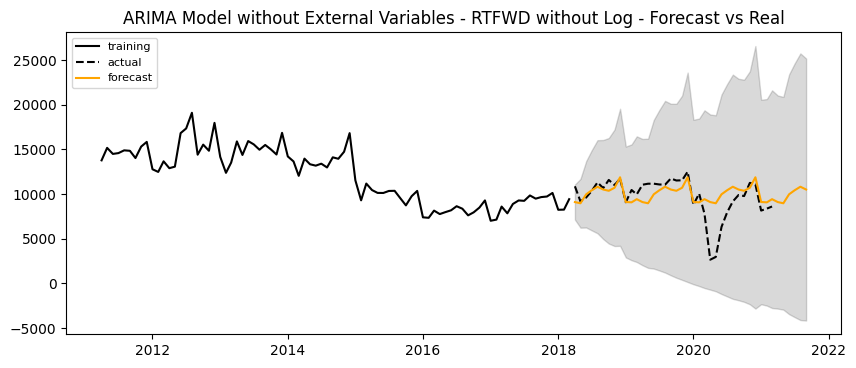

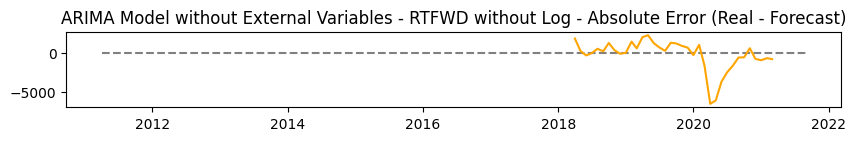

In [57]:
print('ARIMA Model w/o Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_arima_without_external.values[:-6], forecast_arima_without_external.values[:-6]), 3), ' - MAPE:', round(mean_absolute_percentage_error(test_arima_without_external.values[:-6], forecast_arima_without_external.values[:-6]), 3))
plot_forecast(forecast_arima_without_external, train_arima_without_external, test_arima_without_external, lower_arima_without_external.values, upper_arima_without_external.values, 'ARIMA Model without External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_without_external, absolute_error_test_arima_without_external['RTFWD difference'], 'ARIMA Model without External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

ARIMA Model w/o Ext. Var. - RTFWD with Log - R2:  0.234  - MAPE: 0.22


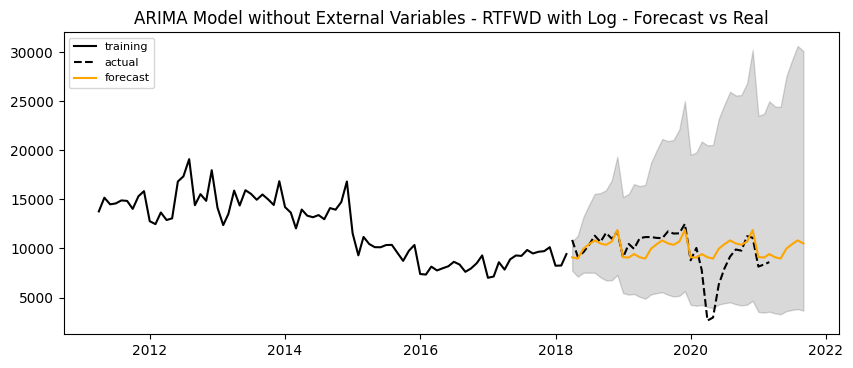

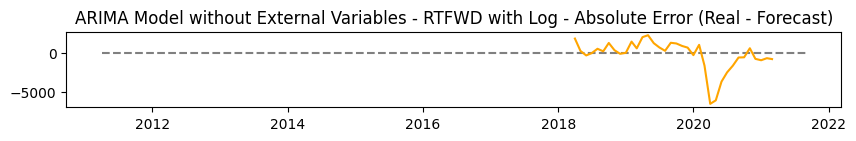

In [58]:
print('ARIMA Model w/o Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_arima_without_external_log.values[:-6], forecast_arima_without_external_log.values[:-6]), 3), ' - MAPE:', round(mean_absolute_percentage_error(test_arima_without_external_log.values[:-6], forecast_arima_without_external_log.values[:-6]), 3))
plot_forecast(forecast_arima_without_external_log, train_arima_without_external_log, test_arima_without_external_log, lower_arima_without_external_log.values, upper_arima_without_external_log.values, 'ARIMA Model without External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_without_external_log, absolute_error_test_arima_without_external_log['RTFWD difference'], 'ARIMA Model without External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

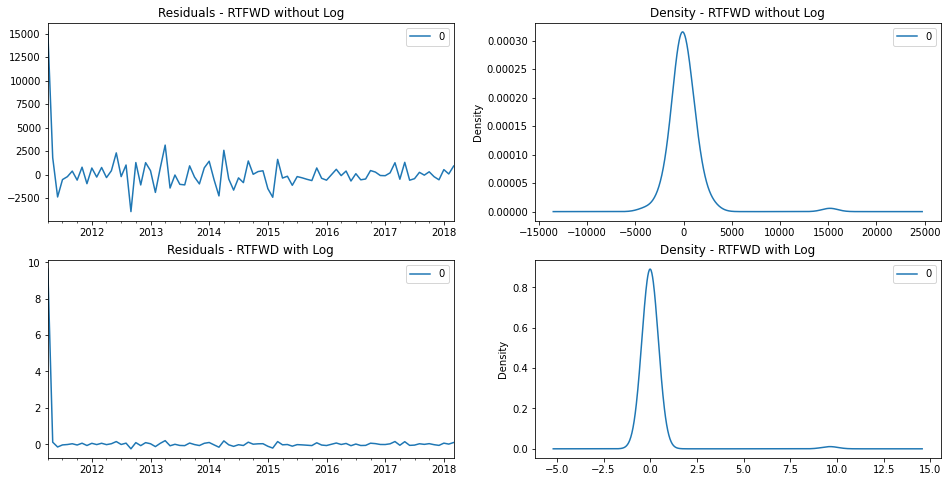

In [59]:
# ARIMA model without External Variables - Check residuals for inference validity
# ANALYSIS - Confidence Interval: we can trust our "confidence interval"?
# CONCLUSION - Confidence Interval: residals of equal variance over time => we can trust our "confidence interval"
#                                   looks normally distributed => we can trust our "confidence interval"
residuals = pd.DataFrame(arima_model.resid); residuals_log = pd.DataFrame(arima_model_log.resid)
fig, ax = plt.subplots(2, 2, figsize=(16,8))
residuals.plot(title="Residuals - RTFWD without Log", xlabel='', ax=ax[0, 0]); residuals.plot(kind='kde', title='Density - RTFWD without Log', ax=ax[0, 1])
residuals_log.plot(title="Residuals - RTFWD with Log", xlabel='', ax=ax[1, 0]); residuals_log.plot(kind='kde', title='Density - RTFWD with Log', ax=ax[1, 1]);

In [60]:
# Amount of vehicle registrations forecasted to the next 6 months

forecasted_registrations = pd.DataFrame(forecast_arima_without_external[-6:])
forecasted_registrations.columns = ['RTFWD forecasted - modeling without log']
forecasted_registrations['RTFWD forecasted - modeling with log'] = forecast_arima_without_external_log[-6:]
forecasted_registrations

,RTFWD forecasted - modeling without log,RTFWD forecasted - modeling with log
2021-04-01,9100.477516,9100.477516
2021-05-01,8967.928718,8967.928718
2021-06-01,9973.064266,9973.064266
2021-07-01,10421.355885,10421.355885
2021-08-01,10819.024086,10819.024086
2021-09-01,10505.461864,10505.461864


## Merging External Variables

In [61]:
# Merge with the base data

anfavea_sta_augmented = pd.merge(anfavea_sta.reset_index(), ibge_lspa_6588.reset_index(), how='left', on='Month')
anfavea_sta_augmented = pd.merge(anfavea_sta_augmented, ibge_pimpf_3653.reset_index(), how='left', on='Month')
anfavea_sta_augmented = pd.merge(anfavea_sta_augmented, ibge_pmc_3416.reset_index(), how='left', on='Month')
anfavea_sta_augmented = pd.merge(anfavea_sta_augmented, ibge_pms_6442.reset_index(), how='left', on='Month')
anfavea_sta_augmented = pd.merge(anfavea_sta_augmented, ibge_ipca_1737.reset_index(), how='left', on='Month')
anfavea_sta_augmented = anfavea_sta_augmented.set_index('Month')
anfavea_sta_augmented.head()

,Registrations - Total,Registrations - Passengers Cars,Registrations - Light Commercials,Registrations - Trucks,Registrations - Buses,RTFWD,RPCFWD,RLCFWD,RTRFWD,RBUFWD,RTFWD deseasonalized,RTFWD deseasonalized log,Agriculture,Industry,Commerce,Services,Inflation
Month,,,,,,,,,,,,,,,,,
2011-04-01,289189.0,231694.0,41222.0,13512.0,2761.0,13770.904762,11033.047619,1962.952381,643.428571,131.476190,15174.957659,9.627402,65163204.0,97.5,82.9,86.7,3299.07
2011-05-01,318534.0,253981.0,46548.0,15137.0,2868.0,15168.285714,12094.333333,2216.571429,720.809524,136.571429,16961.862848,9.738723,65513320.0,107.1,84.8,89.8,3314.58
2011-06-01,304333.0,242534.0,44390.0,14795.0,2614.0,14492.047619,11549.238095,2113.809524,704.523810,124.476190,14572.374676,9.586883,65665703.0,102.8,82.5,89.0,3319.55
2011-07-01,306231.0,242067.0,45899.0,15550.0,2715.0,14582.428571,11527.000000,2185.666667,740.476190,129.285714,14032.492699,9.549131,65532580.0,106.1,85.3,90.7,3324.86
2011-08-01,327610.0,258414.0,49621.0,16459.0,3116.0,14891.363636,11746.090909,2255.500000,748.136364,141.636364,13803.066348,9.532646,65544826.0,110.8,85.7,92.8,3337.16


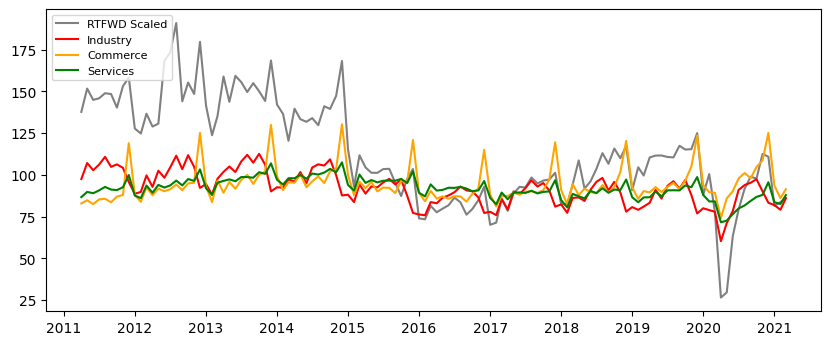

In [62]:
# Plot all features
# ANALYSIS - External Variables Selection: which external variables should we used?
#                                          trend similar to main feature RTFWD => use
# CONCLUSION - External Variables Selection: use external variables Industry, Commerce and Services
anfavea_sta_augmented['RTFWD scaled'] = anfavea_sta_augmented['RTFWD'] / 100
plt.figure(figsize=(10,4), dpi=100)
plt.plot(anfavea_sta_augmented[['RTFWD scaled']], label='RTFWD Scaled', color='gray')
plt.plot(anfavea_sta_augmented[['Industry']], label='Industry', color='red')
plt.plot(anfavea_sta_augmented[['Commerce']], label='Commerce', color='orange')
plt.plot(anfavea_sta_augmented[['Services']], label='Services', color='green')
plt.legend(loc='upper left', fontsize=8);

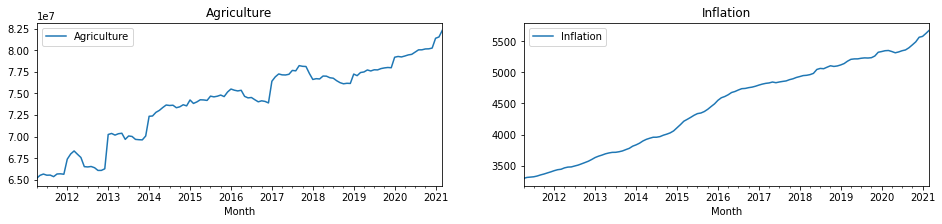

In [63]:
# Plot all features
# ANALYSIS - External Variables Selection: which external variables should we used?
#                                          trend similar to main feature RTFWD => use
# CONCLUSION - External Variables Selection: DO NOT use external variables Agriculture and Inflation

fig, ax = plt.subplots(1,2, figsize=(16,3))
anfavea_sta_augmented[['Agriculture']].plot(title="Agriculture", ax=ax[0])
anfavea_sta_augmented[['Inflation']].plot(title="Inflation", ax=ax[1]);

## Removing Seasons from External Variables

In [64]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_dec_add_ind = seasonal_decompose(anfavea_sta_augmented['Industry'], model='additive')

# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_dec_mul_ind = seasonal_decompose(anfavea_sta_augmented['Industry'], model='multiplicative')

# ADF test on the residuals to decide between Additive X Multiplicative Decomposition
print('Industry - additive resid: ', adfuller(result_dec_add_ind.resid.dropna())[1])
print('Industry - multipl resid: ', adfuller(result_dec_mul_ind.resid.dropna())[1])

Industry - additive resid:  0.004595897808952729
Industry - multipl resid:  0.001335609746897427


In [65]:
# Remove seasons

anfavea_sta_augmented['Industry deseasonalized'] = anfavea_sta_augmented['Industry'].values / result_dec_mul_ind.seasonal

In [66]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_dec_add_com = seasonal_decompose(anfavea_sta_augmented['Commerce'], model='additive')

# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_dec_mul_com = seasonal_decompose(anfavea_sta_augmented['Commerce'], model='multiplicative')

# ADF test on the residuals to decide between Additive X Multiplicative Decomposition
print('Commerce - additive resid: ', adfuller(result_dec_add_com.resid.dropna())[1])
print('Commerce - multipl resid: ', adfuller(result_dec_mul_com.resid.dropna())[1])

Commerce - additive resid:  2.4865093062765945e-09
Commerce - multipl resid:  1.3803324631942222e-08


In [67]:
# Remove seasons

anfavea_sta_augmented['Commerce deseasonalized'] = anfavea_sta_augmented['Commerce'].values / result_dec_mul_com.seasonal

In [68]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_dec_add_ser = seasonal_decompose(anfavea_sta_augmented['Services'], model='additive')

# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_dec_mul_ser = seasonal_decompose(anfavea_sta_augmented['Services'], model='multiplicative')

# ADF test on the residuals to decide between Additive X Multiplicative Decomposition
print('Services - additive resid: ', adfuller(result_dec_add_ser.resid.dropna())[1])
print('Services - multipl resid: ', adfuller(result_dec_mul_ser.resid.dropna())[1])

Services - additive resid:  1.0808137961256848e-06
Services - multipl resid:  1.0359855715077971e-07


In [69]:
# Remove seasons

anfavea_sta_augmented['Services deseasonalized'] = anfavea_sta_augmented['Services'].values / result_dec_mul_ser.seasonal

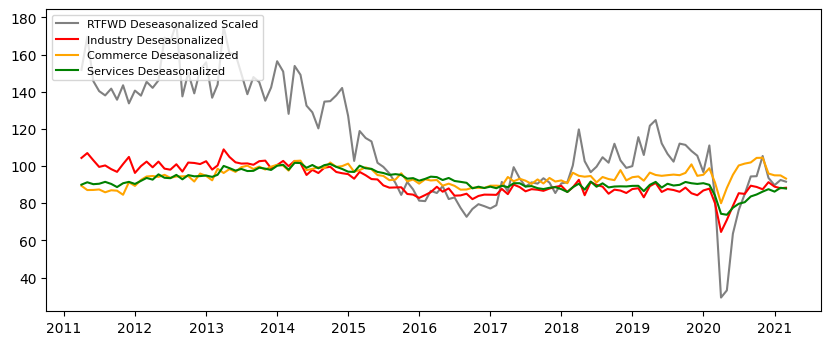

In [70]:
# Plot all features without seasons
anfavea_sta_augmented['RTFWD deseasonalized scaled'] = anfavea_sta_augmented['RTFWD deseasonalized'] / 100
plt.figure(figsize=(10,4), dpi=100)
plt.plot(anfavea_sta_augmented[['RTFWD deseasonalized scaled']], label='RTFWD Deseasonalized Scaled', color='gray')
plt.plot(anfavea_sta_augmented[['Industry deseasonalized']], label='Industry Deseasonalized', color='red')
plt.plot(anfavea_sta_augmented[['Commerce deseasonalized']], label='Commerce Deseasonalized', color='orange')
plt.plot(anfavea_sta_augmented[['Services deseasonalized']], label='Services Deseasonalized', color='green')
plt.legend(loc='upper left', fontsize=8);

## ARIMA Model with External Variables

In [71]:
# Training/Test split

train = anfavea_sta_augmented[:-36]
test = anfavea_sta_augmented[-36:]

In [72]:
# ARIMA model with External Variables - RTFWD Deseasonalized without Log
# Search for best order hyperparameters automatically
arima_model = pm.auto_arima(train['RTFWD deseasonalized'],
                            X=train[['Industry', 'Commerce', 'Services']].diff(1).fillna(0),
                            start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1399.882, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1401.867, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1401.507, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1398.221, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1397.896, Time=1.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1394.728, Time=1.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.994, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1395.300, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1396.880, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1396.466, Time=1.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1393.335, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1391.721, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.289, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1393.632, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [73]:
# ARIMA model with External Variables - RTFWD Deseasonalized with Log
# Search for best order hyperparameters automatically
arima_model_log = pm.auto_arima(train['RTFWD deseasonalized log'],
                                X=train[['Industry', 'Commerce', 'Services']].diff(1).fillna(0),
                                start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-179.040, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-179.321, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-181.441, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-180.639, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-177.996, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-182.822, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-181.008, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-181.662, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-180.466, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-183.355, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-182.130, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-181.531, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-182.007, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-182.754, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [74]:
# ARIMA model without External Variables - RTFWD Deseasonalized without Log
# Order hyperparameters automatically chosen with manual ajust
# Build Model
arima_model = ARIMA(train['RTFWD deseasonalized'],
                    exog=train[['Industry', 'Commerce', 'Services']].diff(1).fillna(0), order=(0, 1, 0))
arima_model = arima_model.fit()
# Forecast
forecast_results = \
    arima_model.get_forecast(len(test), exog=test[['Industry', 'Commerce', 'Services']].diff(1).fillna(0), alpha=0.05)  # 95% confidence
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
# Model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     RTFWD deseasonalized   No. Observations:                   84
Model:                   ARIMA(0, 1, 0)   Log Likelihood                -695.110
Date:                  Wed, 24 Aug 2022   AIC                           1398.221
Time:                          13:42:17   BIC                           1407.896
Sample:                      04-01-2011   HQIC                          1402.108
                           - 03-01-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Industry       8.2387     15.731      0.524      0.600     -22.594      39.072
Commerce     -33.4569     21.152     -1.582      0.114     -74.914       8.000
Services      87.0343     54.604      1.594      0.111     -19.988     194.057
sigma2       1.09e+06   1.19e+05      9.129      0.000    8.56e+05    1.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.51   Jarque-Bera (JB):                15.95
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
# ARIMA model without External Variables - RTFWD Deseasonalized with Log
# Order hyperparameters automatically chosen with manual ajust
# Build Model
arima_model_log = ARIMA(train['RTFWD deseasonalized log'],
                        exog=train[['Industry', 'Commerce', 'Services']].diff(1).fillna(0), order=(0, 1, 0))
arima_model_log = arima_model_log.fit()
# Forecast
forecast_results = \
    arima_model.get_forecast(len(test), exog=test[['Industry', 'Commerce', 'Services']].diff(1).fillna(0), alpha=0.05)  # 95% confidence
forecast_log = forecast_results.predicted_mean
confidence_int_log = forecast_results.conf_int().values
# Model summary
arima_model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     RTFWD deseasonalized log   No. Observations:                   84
Model:                       ARIMA(0, 1, 0)   Log Likelihood                  94.320
Date:                      Wed, 24 Aug 2022   AIC                           -180.639
Time:                              13:42:17   BIC                           -170.964
Sample:                          04-01-2011   HQIC                          -176.752
                               - 03-01-2018                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Industry       0.0007      0.001      0.626      0.531      -0.002       0.003
Commerce      -0.0026      0.002     -1.676      0.094      -0.006       0.000
Services       0.0071      0.004      1.824      0.068      -0.001       0.015
sigma2         0.0060      0.001      7.533      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.15   Prob(JB):                         0.12
Heteroskedasticity (H):               0.34   Skew:                            -0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# Recompose seasonality in the series, and apply exponential to cancel log if applicable

# RTFWD Deseasonalized without Log
forecast_arima_with_external = forecast * result_dec_mul.seasonal[-36:]
train_arima_with_external = train['RTFWD deseasonalized'] * result_dec_mul.seasonal[:-36]
test_arima_with_external = test['RTFWD deseasonalized'] * result_dec_mul.seasonal[-36:]
lower_arima_with_external = confidence_int[:,0] * result_dec_mul.seasonal[-36:]
upper_arima_with_external = confidence_int[:,1] * result_dec_mul.seasonal[-36:]

# RTFWD Deseasonalized with Log
forecast_arima_with_external_log = np.exp(forecast_log) * result_dec_mul.seasonal[-36:]
train_arima_with_external_log = np.exp(train['RTFWD deseasonalized log']) * result_dec_mul.seasonal[:-36]
test_arima_with_external_log = np.exp(test['RTFWD deseasonalized log']) * result_dec_mul.seasonal[-36:]
lower_arima_with_external_log = np.exp(confidence_int_log[:,0]) * result_dec_mul.seasonal[-36:]
upper_arima_with_external_log = np.exp(confidence_int_log[:,1]) * result_dec_mul.seasonal[-36:]

In [77]:
# Calculate absolute error

# RTFWD Deseasonalized without Log
absolute_error_zero_arima_with_external = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_arima_with_external['RTFWD'] = 0
absolute_error_test_arima_with_external = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_arima_with_external['RTFWD forecasted'] = forecast_arima_with_external
absolute_error_test_arima_with_external['RTFWD difference'] = \
    absolute_error_test_arima_with_external['RTFWD'] - absolute_error_test_arima_with_external['RTFWD forecasted']

# RTFWD Deseasonalized with Log
absolute_error_zero_arima_with_external_log = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_arima_with_external_log['RTFWD'] = 0
absolute_error_test_arima_with_external_log = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_arima_with_external_log['RTFWD forecasted'] = forecast_arima_with_external_log
absolute_error_test_arima_with_external_log['RTFWD difference'] = \
    absolute_error_test_arima_with_external_log['RTFWD'] - absolute_error_test_arima_with_external_log['RTFWD forecasted']

ARIMA model with Ext. Var. - RTFWD w/o Log - R2:  0.27  - MAPE:  0.219


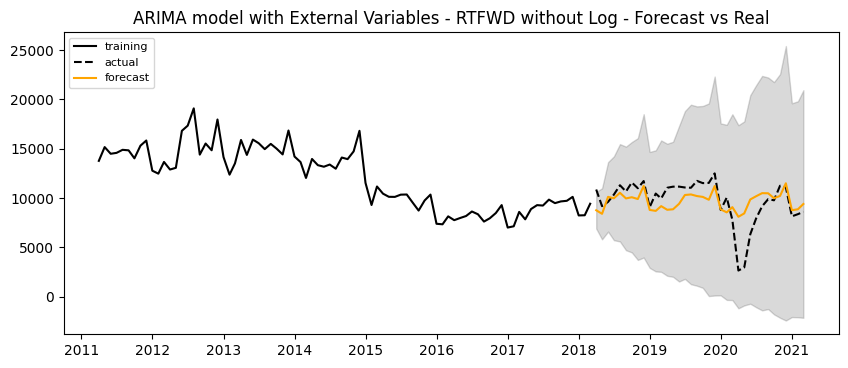

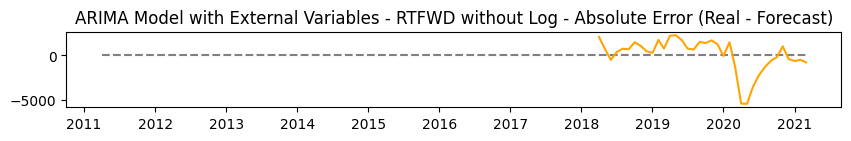

In [78]:
print('ARIMA model with Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_arima_with_external.values, forecast_arima_with_external.values), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_arima_with_external.values, forecast_arima_with_external.values), 3))
plot_forecast(forecast_arima_with_external, train_arima_with_external, test_arima_with_external, lower_arima_with_external.values, upper_arima_with_external.values, 'ARIMA model with External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_with_external, absolute_error_test_arima_with_external['RTFWD difference'], 'ARIMA Model with External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

ARIMA model with Ext. Var. - RTFWD with Log - R2:  -20.363  - MAPE:  1.0


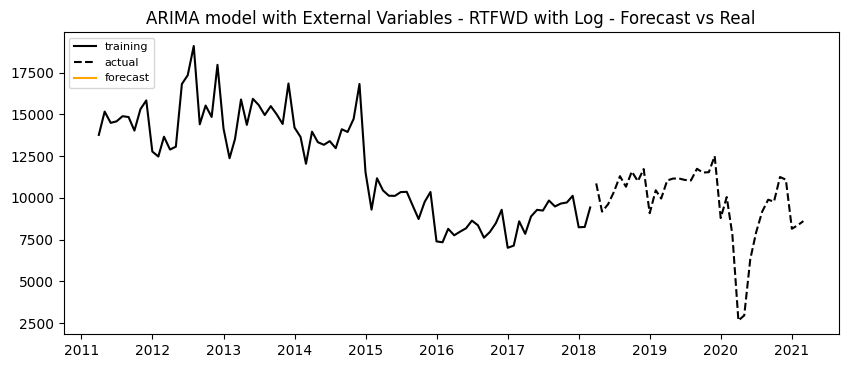

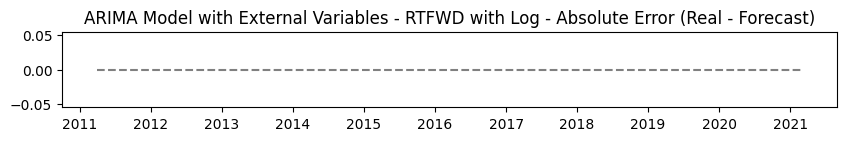

In [79]:
print('ARIMA model with Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_arima_with_external_log.values, np.nan_to_num(forecast_arima_with_external_log.values, posinf=0, neginf=0)), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_arima_with_external_log.values, np.nan_to_num(forecast_arima_with_external_log.values, posinf=0, neginf=0)), 3))
plot_forecast(forecast_arima_with_external_log, train_arima_with_external_log, test_arima_with_external_log, lower_arima_with_external_log.values, upper_arima_with_external_log.values, 'ARIMA model with External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_with_external_log, absolute_error_test_arima_with_external_log['RTFWD difference'], 'ARIMA Model with External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

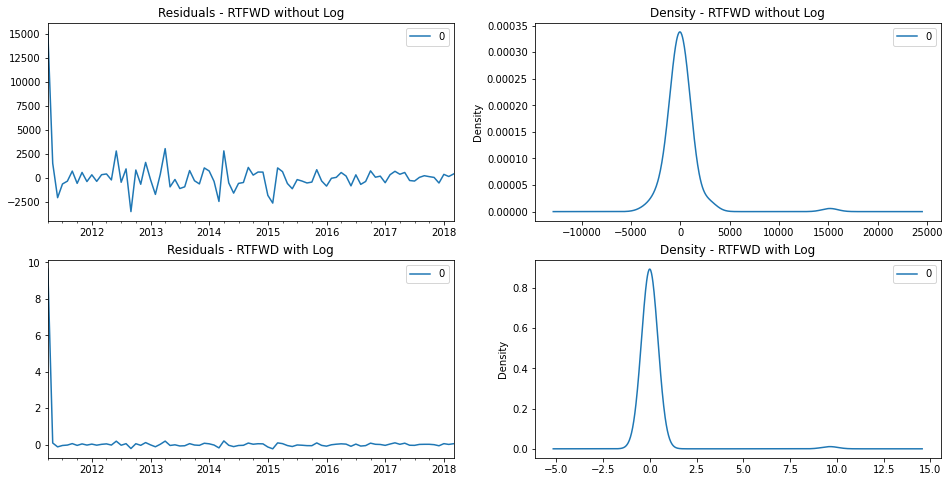

In [80]:
# ARIMA model without External Variables - Check residuals for inference validity
# ANALYSIS - Confidence Interval: we can trust our "confidence interval"?
# CONCLUSION - Confidence Interval: residals of equal variance over time => we can trust our "confidence interval"
#                                   looks normally distributed => we can trust our "confidence interval"
residuals = pd.DataFrame(arima_model.resid); residuals_log = pd.DataFrame(arima_model_log.resid)
fig, ax = plt.subplots(2, 2, figsize=(16,8))
residuals.plot(title="Residuals - RTFWD without Log", xlabel='', ax=ax[0, 0]); residuals.plot(kind='kde', title='Density - RTFWD without Log', ax=ax[0, 1])
residuals_log.plot(title="Residuals - RTFWD with Log", xlabel='', ax=ax[1, 0]); residuals_log.plot(kind='kde', title='Density - RTFWD with Log', ax=ax[1, 1]);

In [81]:
# Amount of vehicle registrations forecasted to the next 6 months

# EXTERNAL VARIABLES FORECAST TO THE NEXT 6 MONTHS NEEDED TO FORECAST REGISTRATIONS TO THE NEXT 6 MONTHS

## SVR Model without External Variables

In [82]:
# Generate 12 auto-regressive features

anfavea_sta_svr = anfavea_sta[['RTFWD']].copy()

for i in range(1, 13):
    anfavea_sta_svr[f't - {i}'] = anfavea_sta['RTFWD'].shift(i)

anfavea_sta_svr.dropna(inplace=True)
anfavea_sta_svr.head()

,RTFWD,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Month,,,,,,,,,,,,,
2012-04-01,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714,13770.904762
2012-05-01,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714
2012-06-01,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619
2012-07-01,17342.666667,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571
2012-08-01,19094.545455,17342.666667,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636


In [83]:
# Training/Test and X/y Split

train = anfavea_sta_svr[:-36]
test = anfavea_sta_svr[-36:]

train_X = train.drop(columns = ['RTFWD'])
train_y = train['RTFWD']
test_X = test.drop(columns = ['RTFWD'])
test_y = test['RTFWD']

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(72, 12) (72,) (36, 12) (36,)


In [84]:
%%time

# SVR Model without External Variables - RTFWD without Log
# Kernel Linear - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['linear'],
        'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01]}

# Instanciate Grid Search
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_linear.fit(train_X, train_y)

print('SVR Model without External Variables - RTFWD without Log - Linear - Best Params: \n    ', search_svr_linear.best_params_)
print('SVR Model without External Variables - RTFWD without Log - Linear - R2: ',
      round(r2_score(test_y, search_svr_linear.predict(test_X)), 3))
print('SVR Model without External Variables - RTFWD without Log - Linear - MAPE: ',
      round(mean_absolute_percentage_error(test_y, search_svr_linear.predict(test_X)), 3))

SVR Model without External Variables - RTFWD without Log - Linear - Best Params: 
     {'C': 0.0001, 'kernel': 'linear'}
SVR Model without External Variables - RTFWD without Log - Linear - R2:  0.413
SVR Model without External Variables - RTFWD without Log - Linear - MAPE:  0.188
CPU times: user 168 ms, sys: 61.2 ms, total: 229 ms
Wall time: 1.95 s


In [85]:
%%time

# SVR Model without External Variables - RTFWD with Log
# Kernel Linear - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}

# Instanciate Grid Search
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

print('SVR Model without External Variables - RTFWD with Log - Linear - Best Params: \n    ', search_svr_linear_log.best_params_)
print('SVR Model without External Variables - Linear - R2: ',
      round(r2_score(test_y, np.exp(search_svr_linear_log.predict(np.log(test_X)))), 3))
print('SVR Model without External Variables - RTFWD with Log - Linear - MAPE: ',
      round(mean_absolute_percentage_error(test_y, np.exp(search_svr_linear_log.predict(np.log(test_X)))), 3))

SVR Model without External Variables - RTFWD with Log - Linear - Best Params: 
     {'C': 1, 'kernel': 'linear'}
SVR Model without External Variables - Linear - R2:  0.426
SVR Model without External Variables - RTFWD with Log - Linear - MAPE:  0.188
CPU times: user 106 ms, sys: 7.3 ms, total: 113 ms
Wall time: 681 ms


In [86]:
%%time

# SVR Model without External Variables - RTFWD without Log
# Kernel RBF - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['rbf'],
        'gamma': [1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
        'C': [100, 1000, 10000, 100000, 1000000]}

# Instanciate Grid Search
search_svr_rbf = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_rbf.fit(train_X, train_y)

print('SVR Model without External Variables - RTFWD without Log - RBF - Best Params: \n    ', search_svr_rbf.best_params_)
print('SVR Model without External Variables - RTFWD without Log - RBF - R2: ',
      round(r2_score(test_y, search_svr_rbf.predict(test_X)), 3))
print('SVR Model without External Variables - RTFWD without Log - RBF - MAPE: ',
      round(mean_absolute_percentage_error(test_y, search_svr_rbf.predict(test_X)), 3))

SVR Model without External Variables - RTFWD without Log - RBF - Best Params: 
     {'C': 10000, 'gamma': 1e-09, 'kernel': 'rbf'}
SVR Model without External Variables - RTFWD without Log - RBF - R2:  0.256
SVR Model without External Variables - RTFWD without Log - RBF - MAPE:  0.222
CPU times: user 200 ms, sys: 6.49 ms, total: 207 ms
Wall time: 627 ms


In [87]:
%%time

# SVR Model without External Variables - RTFWD with Log
# Kernel RBF - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['rbf'],
        'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 1e-04],
        'C': [10000, 100000, 1000000, 10000000, 100000000]}

# Instanciate Grid Search
search_svr_rbf_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_rbf_log.fit(np.log(train_X), np.log(train_y))

print('SVR Model without External Variables - RTFWD with Log - RBF - Best Params: \n    ', search_svr_rbf_log.best_params_)
print('SVR Model without External Variables - RTFWD with Log - RBF - R2: ',
      round(r2_score(test_y, np.exp(search_svr_rbf_log.predict(np.log(test_X)))), 3))
print('SVR Model without External Variables - RTFWD with Log - RBF - MAPE: ',
      round(mean_absolute_percentage_error(test_y, np.exp(search_svr_rbf_log.predict(np.log(test_X)))), 3))

SVR Model without External Variables - RTFWD with Log - RBF - Best Params: 
     {'C': 1000000, 'gamma': 1e-06, 'kernel': 'rbf'}
SVR Model without External Variables - RTFWD with Log - RBF - R2:  0.369
SVR Model without External Variables - RTFWD with Log - RBF - MAPE:  0.2
CPU times: user 239 ms, sys: 2.98 ms, total: 242 ms
Wall time: 1.21 s


In [88]:
# Save the results

# RTFWD without Log
forecast_svr_without_external = search_svr_linear.predict(test_X)
train_svr_without_external = train_y
test_svr_without_external = test_y
lower_svr_without_external = None
upper_svr_without_external = None

# RTFWD with Log
forecast_svr_without_external_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))
train_svr_without_external_log = train_y
test_svr_without_external_log = test_y
lower_svr_without_external_log = None
upper_svr_without_external_log = None

In [89]:
# Calculate absolute error

# RTFWD without Log
absolute_error_zero_svr_without_external = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_svr_without_external['RTFWD'] = 0
absolute_error_test_svr_without_external = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_svr_without_external['RTFWD forecasted'] = forecast_svr_without_external
absolute_error_test_svr_without_external['RTFWD difference'] = \
    absolute_error_test_svr_without_external['RTFWD'] - absolute_error_test_svr_without_external['RTFWD forecasted']

# RTFWD with Log
absolute_error_zero_svr_without_external_log = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_svr_without_external_log['RTFWD'] = 0
absolute_error_test_svr_without_external_log = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_svr_without_external_log['RTFWD forecasted'] = forecast_svr_without_external_log
absolute_error_test_svr_without_external_log['RTFWD difference'] = \
    absolute_error_test_svr_without_external_log['RTFWD'] - absolute_error_test_svr_without_external_log['RTFWD forecasted']

SVR Model w/o Ext. Var. - RTFWD w/o Log - Linear - R2:  0.413  - MAPE:  0.188


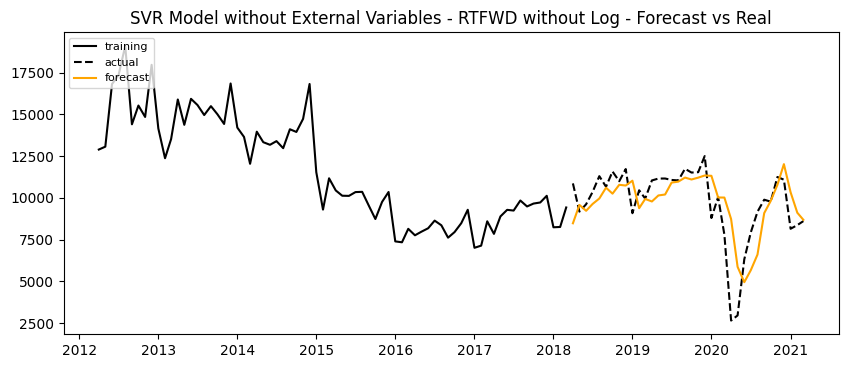

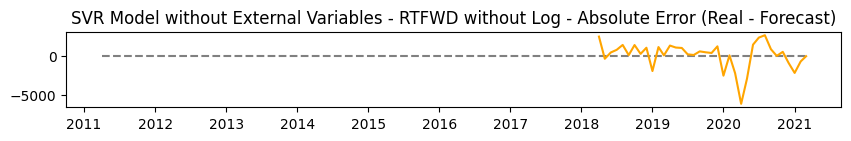

In [90]:
print('SVR Model w/o Ext. Var. - RTFWD w/o Log - Linear - R2: ', round(r2_score(test_svr_without_external, forecast_svr_without_external), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_without_external, forecast_svr_without_external), 3))
plot_forecast(forecast_svr_without_external, train_svr_without_external, test_svr_without_external, lower_svr_without_external, upper_svr_without_external, 'SVR Model without External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_without_external, absolute_error_test_svr_without_external['RTFWD difference'], 'SVR Model without External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

SVR Model w/o Ext. Var. - RTFWD with Log - Linear - R2:  0.426  - MAPE:  0.188


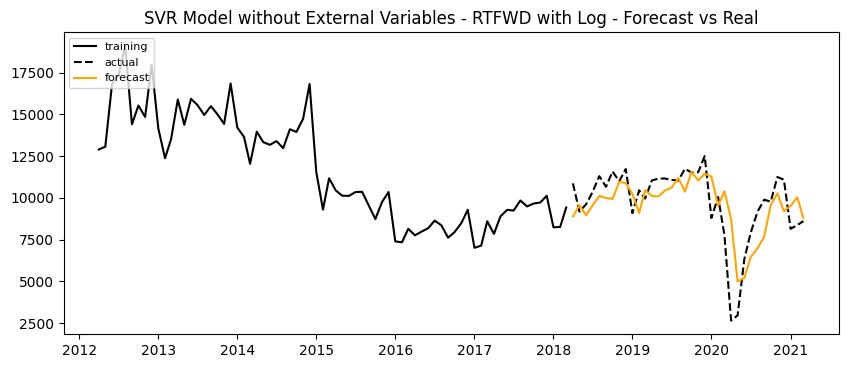

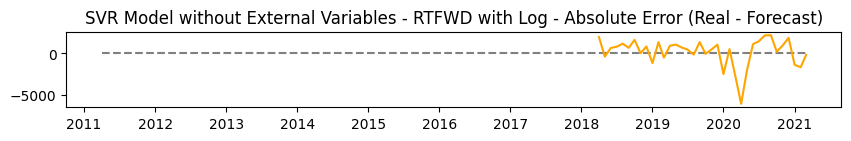

In [91]:
print('SVR Model w/o Ext. Var. - RTFWD with Log - Linear - R2: ', round(r2_score(test_svr_without_external_log, forecast_svr_without_external_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_without_external_log, forecast_svr_without_external_log), 3))
plot_forecast(forecast_svr_without_external_log, train_svr_without_external_log, test_svr_without_external_log, lower_svr_without_external_log, upper_svr_without_external_log, 'SVR Model without External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_without_external_log, absolute_error_test_svr_without_external_log['RTFWD difference'], 'SVR Model without External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

In [92]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return date(year, month, day)

In [93]:
# Amount of vehicle registrations forecasted to the next month

forecast_X = test[-1:]
forecast_X = forecast_X.reset_index()
forecast_X['Month'] = forecast_X['Month'].apply(lambda x: add_months(x, 1))
forecast_X = forecast_X.set_index('Month')
forecast_X = forecast_X.drop(columns = ['t - 12'])
forecast_X.columns = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6',
                      't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12']

forecast_y = forecast_X.copy()
forecast_y['RTFWD forecasted - modeling without log'] = search_svr_linear.predict(forecast_X)[0]
forecast_y['RTFWD forecasted - modeling with log'] = np.exp(search_svr_linear_log.predict(np.log(forecast_X)))[0]
forecast_y = forecast_y[['RTFWD forecasted - modeling without log', 'RTFWD forecasted - modeling with log']]
forecast_y

,RTFWD forecasted - modeling without log,RTFWD forecasted - modeling with log
Month,,
2021-04-01,7103.32732,6510.293702


## SVR Model with External Variables

In [94]:
# Generate 12 auto-regressive features

anfavea_sta_augmented_svr = anfavea_sta_augmented[['RTFWD', 'Industry', 'Commerce', 'Services']].copy()

for i in range(1, 13):
    anfavea_sta_augmented_svr[f't - {i}'] = anfavea_sta_augmented['RTFWD'].shift(i)

anfavea_sta_augmented_svr.dropna(inplace=True)
anfavea_sta_augmented_svr.head()

,RTFWD,Industry,Commerce,Services,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Month,,,,,,,,,,,,,,,,
2012-04-01,12894.350000,92.8,87.8,89.3,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714,13770.904762
2012-05-01,13066.590909,102.5,91.7,94.0,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619,15168.285714
2012-06-01,16819.047619,98.3,90.2,92.4,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571,14492.047619
2012-07-01,17342.666667,104.5,91.4,93.7,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636,14582.428571
2012-08-01,19094.545455,111.5,94.2,96.6,17342.666667,16819.047619,13066.590909,12894.350000,13662.454545,12475.850000,12774.904762,15837.045455,15312.380952,14028.350000,14840.380952,14891.363636


In [95]:
# Training/Test and X/y Split

train = anfavea_sta_augmented_svr[:-36]
test = anfavea_sta_augmented_svr[-36:]

train_X = train.drop(columns = ['RTFWD'])
train_y = train['RTFWD']
test_X = test.drop(columns = ['RTFWD'])
test_y = test['RTFWD']

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(72, 15) (72,) (36, 15) (36,)


In [96]:
%%time

# SVR Model with External Variables - RTFWD without Log
# Kernel Linear - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['linear'],
        'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01]}

# Instanciate Grid Search
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_linear.fit(train_X, train_y)

print('SVR Model with External Variables - RTFWD without Log - Linear - Best Params: \n    ', search_svr_linear.best_params_)
print('SVR Model with External Variables - RTFWD without Log - Linear - R2: ',
      round(r2_score(test_y, search_svr_linear.predict(test_X)), 3))
print('SVR Model with External Variables - RTFWD without Log - Linear - MAPE: ',
      round(mean_absolute_percentage_error(test_y, search_svr_linear.predict(test_X)), 3))

SVR Model with External Variables - RTFWD without Log - Linear - Best Params: 
     {'C': 0.0001, 'kernel': 'linear'}
SVR Model with External Variables - RTFWD without Log - Linear - R2:  0.413
SVR Model with External Variables - RTFWD without Log - Linear - MAPE:  0.188
CPU times: user 130 ms, sys: 5.47 ms, total: 136 ms
Wall time: 3.12 s


In [97]:
%%time

# SVR Model with External Variables - RTFWD with Log
# Kernel Linear - Automatic search for the best hyperparameters

# Instanciate model
svr_model = SVR()

# Hyperparameter Grid
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}

# Instanciate Grid Search
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)

# Fit data to Grid Search
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

print('SVR Model with External Variables - RTFWD with Log - Linear - Best Params: \n    ', search_svr_linear_log.best_params_)
print('SVR Model with External Variables - RTFWD with Log - Linear - R2: ',
      round(r2_score(test_y, np.exp(search_svr_linear_log.predict(np.log(test_X)))), 3))
print('SVR Model with External Variables - RTFWD with Log - Linear - MAPE: ',
      round(mean_absolute_percentage_error(test_y, np.exp(search_svr_linear_log.predict(np.log(test_X)))), 3))

SVR Model with External Variables - RTFWD with Log - Linear - Best Params: 
     {'C': 10, 'kernel': 'linear'}
SVR Model with External Variables - RTFWD with Log - Linear - R2:  0.597
SVR Model with External Variables - RTFWD with Log - Linear - MAPE:  0.132
CPU times: user 103 ms, sys: 1.52 ms, total: 105 ms
Wall time: 737 ms


In [98]:
# Save the results

# RTFWD without Log
forecast_svr_with_external = search_svr_linear.predict(test_X)
train_svr_with_external = train_y
test_svr_with_external = test_y
lower_svr_with_external = None
upper_svr_with_external = None

# RTFWD with Log
forecast_svr_with_external_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))
train_svr_with_external_log = train_y
test_svr_with_external_log = test_y
lower_svr_with_external_log = None
upper_svr_with_external_log = None

In [99]:
# Calculate absolute error

# RTFWD without Log
absolute_error_zero_svr_with_external = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_svr_with_external['RTFWD'] = 0
absolute_error_test_svr_with_external = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_svr_with_external['RTFWD forecasted'] = forecast_svr_with_external
absolute_error_test_svr_with_external['RTFWD difference'] = \
    absolute_error_test_svr_with_external['RTFWD'] - absolute_error_test_svr_with_external['RTFWD forecasted']

# RTFWD with Log
absolute_error_zero_svr_with_external_log = anfavea_sta[['RTFWD']].copy()
absolute_error_zero_svr_with_external_log['RTFWD'] = 0
absolute_error_test_svr_with_external_log = anfavea_sta[['RTFWD']][-36:]
absolute_error_test_svr_with_external_log['RTFWD forecasted'] = forecast_svr_with_external_log
absolute_error_test_svr_with_external_log['RTFWD difference'] = \
    absolute_error_test_svr_with_external_log['RTFWD'] - absolute_error_test_svr_with_external_log['RTFWD forecasted']

SVR Model with Ext. Var. - RTFWD w/o Log - R2:  0.413  - MAPE:  0.188


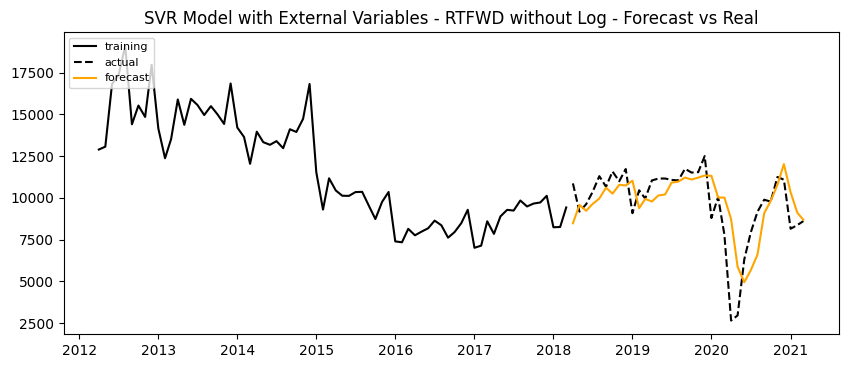

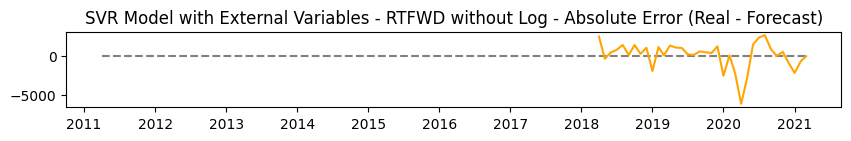

In [100]:
print('SVR Model with Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_svr_with_external, forecast_svr_with_external), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_with_external, forecast_svr_with_external), 3))
plot_forecast(forecast_svr_with_external, train_svr_with_external, test_svr_with_external, lower_svr_with_external, upper_svr_with_external, 'SVR Model with External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_with_external, absolute_error_test_svr_with_external['RTFWD difference'], 'SVR Model with External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

SVR Model with Ext. Var. - RTFWD with Log - R2:  0.597  - MAPE:  0.132


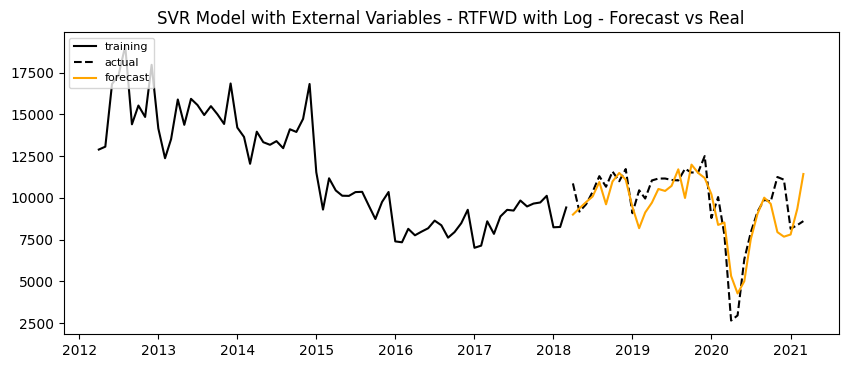

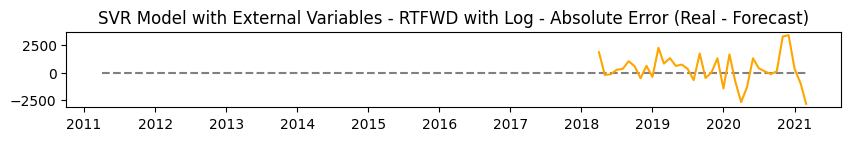

In [101]:
print('SVR Model with Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_svr_with_external_log, forecast_svr_with_external_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_with_external_log, forecast_svr_with_external_log), 3))
plot_forecast(forecast_svr_with_external_log, train_svr_with_external_log, test_svr_with_external_log, lower_svr_with_external_log, upper_svr_with_external_log, 'SVR Model with External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_with_external_log, absolute_error_test_svr_with_external_log['RTFWD difference'], 'SVR Model with External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

In [102]:
# Amount of vehicle registrations forecasted to the next month

# EXOGENOUS FEATURES FORECAST TO THE NEXT MONTH NEEDED TO FORECAST REGISTRATIONS TO THE NEXT MONTH

## Best Model (SVR Model with External Variables) per Vehicles Segments

In [103]:
%%time

# PASSENGER CARS - Best Model (SVR Model without External Variables)

# Generate 12 auto-regressive features
anfavea_sta_augmented_svr = anfavea_sta_augmented[['RPCFWD', 'Industry', 'Commerce', 'Services']].copy()
for i in range(1, 13):
    anfavea_sta_augmented_svr[f't - {i}'] = anfavea_sta_augmented['RPCFWD'].shift(i)
anfavea_sta_augmented_svr.dropna(inplace=True)

# Training/Test and X/y Split
train = anfavea_sta_augmented_svr[:-36]
test = anfavea_sta_augmented_svr[-36:]
train_X = train.drop(columns = ['RPCFWD'])
train_y = train['RPCFWD']
test_X = test.drop(columns = ['RPCFWD'])
test_y = test['RPCFWD']

# Automatic search for the best hyperparameters - RTFWD without Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01]}
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear.fit(train_X, train_y)

# Automatic search for the best hyperparameters - RTFWD with Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

# Save the results - RTFWD without Log
test_best_model_passenger_cars = test_y
forecast_best_model_passenger_cars = search_svr_linear.predict(test_X)

# Save the results - RTFWD with Log
test_best_model_passenger_cars_log = test_y
forecast_best_model_passenger_cars_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))

print('PASSENGER CARS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: \n    ', search_svr_linear.best_params_)
print('PASSENGER CARS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: \n    ', search_svr_linear_log.best_params_)

PASSENGER CARS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: 
     {'C': 0.0001, 'kernel': 'linear'}
PASSENGER CARS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: 
     {'C': 10, 'kernel': 'linear'}
CPU times: user 201 ms, sys: 7.81 ms, total: 208 ms
Wall time: 1.15 s


In [104]:
print('PASSENGER CARS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_passenger_cars, forecast_best_model_passenger_cars), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_passenger_cars, forecast_best_model_passenger_cars), 3))
print('PASSENGER CARS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_passenger_cars_log, forecast_best_model_passenger_cars_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_passenger_cars_log, forecast_best_model_passenger_cars_log), 3))

PASSENGER CARS - Best Model (SVR w/o EV) w/o Log - R2:  0.45  - MAPE:  0.21
PASSENGER CARS - Best Model (SVR w/o EV) with Log - R2:  0.478  - MAPE:  0.177


In [105]:
%%time

# LIGHT COMMERCIALS - Best Model (SVR Model without External Variables)

# Generate 12 auto-regressive features
anfavea_sta_augmented_svr = anfavea_sta_augmented[['RLCFWD', 'Industry', 'Commerce', 'Services']].copy()
for i in range(1, 13):
    anfavea_sta_augmented_svr[f't - {i}'] = anfavea_sta_augmented['RLCFWD'].shift(i)
anfavea_sta_augmented_svr.dropna(inplace=True)

# Training/Test and X/y Split
train = anfavea_sta_augmented_svr[:-36]
test = anfavea_sta_augmented_svr[-36:]
train_X = train.drop(columns = ['RLCFWD'])
train_y = train['RLCFWD']
test_X = test.drop(columns = ['RLCFWD'])
test_y = test['RLCFWD']

# Automatic search for the best hyperparameters - RTFWD without Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01]}
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear.fit(train_X, train_y)

# Automatic search for the best hyperparameters - RTFWD with Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

# Save the results - RTFWD without Log
test_best_model_light_commercials = test_y
forecast_best_model_light_commercials = search_svr_linear.predict(test_X)

# Save the results - RTFWD with Log
test_best_model_light_commercials_log = test_y
forecast_best_model_light_commercials_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))

print('LIGHT COMMERCIALS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: \n    ', search_svr_linear.best_params_)
print('LIGHT COMMERCIALS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: \n    ', search_svr_linear_log.best_params_)

LIGHT COMMERCIALS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: 
     {'C': 0.0001, 'kernel': 'linear'}
LIGHT COMMERCIALS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: 
     {'C': 1, 'kernel': 'linear'}
CPU times: user 219 ms, sys: 3.77 ms, total: 223 ms
Wall time: 1.13 s


In [106]:
print('LIGHT COMMERCIALS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_light_commercials, forecast_best_model_light_commercials), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_light_commercials, forecast_best_model_light_commercials), 3))
print('LIGHT COMMERCIALS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_light_commercials_log, forecast_best_model_light_commercials_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_light_commercials_log, forecast_best_model_light_commercials_log), 3))

LIGHT COMMERCIALS - Best Model (SVR w/o EV) w/o Log - R2:  0.294  - MAPE:  0.157
LIGHT COMMERCIALS - Best Model (SVR w/o EV) with Log - R2:  0.515  - MAPE:  0.127


In [107]:
%%time

# TRUCKS - Best Model (SVR Model without External Variables)

# Generate 12 auto-regressive features
anfavea_sta_augmented_svr = anfavea_sta_augmented[['RTRFWD', 'Industry', 'Commerce', 'Services']].copy()
for i in range(1, 13):
    anfavea_sta_augmented_svr[f't - {i}'] = anfavea_sta_augmented['RTRFWD'].shift(i)
anfavea_sta_augmented_svr.dropna(inplace=True)

# Training/Test and X/y Split
train = anfavea_sta_augmented_svr[:-36]
test = anfavea_sta_augmented_svr[-36:]
train_X = train.drop(columns = ['RTRFWD'])
train_y = train['RTRFWD']
test_X = test.drop(columns = ['RTRFWD'])
test_y = test['RTRFWD']

# Automatic search for the best hyperparameters - RTFWD without Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10]}
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear.fit(train_X, train_y)

# Automatic search for the best hyperparameters - RTFWD with Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

# Save the results - RTFWD without Log
test_best_model_trucks = test_y
forecast_best_model_trucks = search_svr_linear.predict(test_X)

# Save the results - RTFWD without Log
test_best_model_trucks_log = test_y
forecast_best_model_trucks_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))

print('TRUCKS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: \n    ', search_svr_linear.best_params_)
print('TRUCKS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: \n    ', search_svr_linear_log.best_params_)

TRUCKS - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: 
     {'C': 0.1, 'kernel': 'linear'}
TRUCKS - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: 
     {'C': 1, 'kernel': 'linear'}
CPU times: user 589 ms, sys: 27.6 ms, total: 616 ms
Wall time: 40.3 s


In [108]:
print('TRUCKS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_trucks, forecast_best_model_trucks), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_trucks, forecast_best_model_trucks), 3))
print('TRUCKS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_trucks_log, forecast_best_model_trucks_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_trucks_log, forecast_best_model_trucks_log), 3))

TRUCKS - Best Model (SVR w/o EV) w/o Log - R2:  0.115  - MAPE:  0.114
TRUCKS - Best Model (SVR w/o EV) with Log - R2:  0.076  - MAPE:  0.122


In [109]:
%%time

# BUSES - Best Model (SVR Model without External Variables)

# Generate 12 auto-regressive features
anfavea_sta_augmented_svr = anfavea_sta_augmented[['RBUFWD', 'Industry', 'Commerce', 'Services']].copy()
for i in range(1, 13):
    anfavea_sta_augmented_svr[f't - {i}'] = anfavea_sta_augmented['RBUFWD'].shift(i)
anfavea_sta_augmented_svr.dropna(inplace=True)

# Training/Test and X/y Split
train = anfavea_sta_augmented_svr[:-36]
test = anfavea_sta_augmented_svr[-36:]
train_X = train.drop(columns = ['RBUFWD'])
train_y = train['RBUFWD']
test_X = test.drop(columns = ['RBUFWD'])
test_y = test['RBUFWD']

# Automatic search for the best hyperparameters - RTFWD without Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1]}
search_svr_linear = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear.fit(train_X, train_y)

# Automatic search for the best hyperparameters - RTFWD with Log
svr_model = SVR()
grid = {'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]}
search_svr_linear_log = GridSearchCV(svr_model, grid, scoring='r2', cv=5, n_jobs=-1)
search_svr_linear_log.fit(np.log(train_X), np.log(train_y))

# Save the results - RTFWD without Log
test_best_model_buses = test_y
forecast_best_model_buses = search_svr_linear.predict(test_X)

# Save the results - RTFWD with Log
test_best_model_buses_log = test_y
forecast_best_model_buses_log = np.exp(search_svr_linear_log.predict(np.log(test_X)))

print('BUSES - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: \n    ', search_svr_linear.best_params_)
print('BUSES - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: \n    ', search_svr_linear_log.best_params_)

BUSES - Best Model (SVR w/o Ext. Var.) - RTFWD without Log - Best Params: 
     {'C': 0.01, 'kernel': 'linear'}
BUSES - Best Model (SVR w/o Ext. Var.) - RTFWD with Log - Best Params: 
     {'C': 1, 'kernel': 'linear'}
CPU times: user 212 ms, sys: 11.2 ms, total: 224 ms
Wall time: 2.28 s


In [110]:
print('BUSES - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_buses, forecast_best_model_buses), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_buses, forecast_best_model_buses), 3))
print('BUSES - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_buses_log, forecast_best_model_buses_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_buses_log, forecast_best_model_buses_log), 3))

BUSES - Best Model (SVR w/o EV) w/o Log - R2:  0.393  - MAPE:  0.181
BUSES - Best Model (SVR w/o EV) with Log - R2:  0.343  - MAPE:  0.21


## Summary

ARIMA Model w/o Ext. Var. - RTFWD w/o Log - R2:  0.234  - MAPE: 0.22


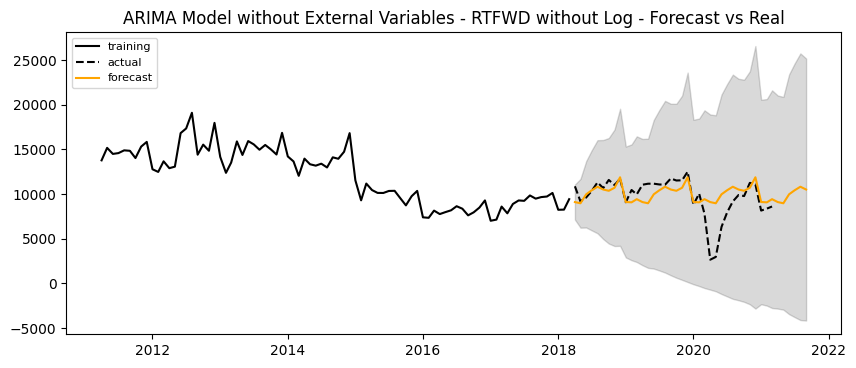

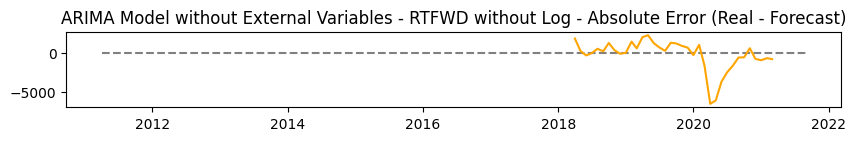

In [111]:
print('ARIMA Model w/o Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_arima_without_external.values[:-6], forecast_arima_without_external.values[:-6]), 3), ' - MAPE:', round(mean_absolute_percentage_error(test_arima_without_external.values[:-6], forecast_arima_without_external.values[:-6]), 3))
plot_forecast(forecast_arima_without_external, train_arima_without_external, test_arima_without_external, lower_arima_without_external.values, upper_arima_without_external.values, 'ARIMA Model without External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_without_external, absolute_error_test_arima_without_external['RTFWD difference'], 'ARIMA Model without External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

ARIMA Model w/o Ext. Var. - RTFWD with Log - R2:  0.234  - MAPE: 0.22


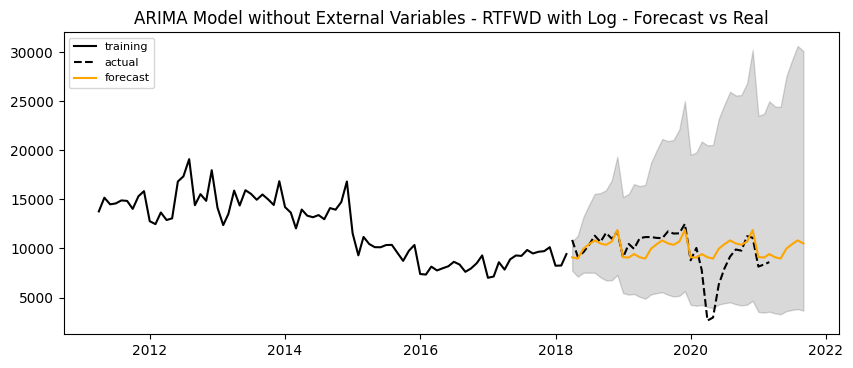

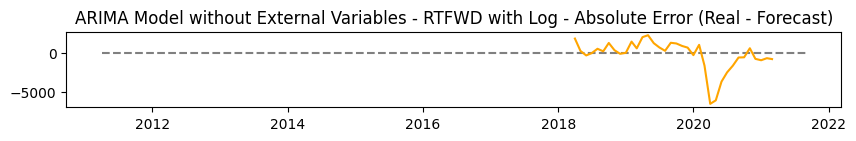

In [112]:
print('ARIMA Model w/o Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_arima_without_external_log.values[:-6], forecast_arima_without_external_log.values[:-6]), 3), ' - MAPE:', round(mean_absolute_percentage_error(test_arima_without_external_log.values[:-6], forecast_arima_without_external_log.values[:-6]), 3))
plot_forecast(forecast_arima_without_external_log, train_arima_without_external_log, test_arima_without_external_log, lower_arima_without_external_log.values, upper_arima_without_external_log.values, 'ARIMA Model without External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_without_external_log, absolute_error_test_arima_without_external_log['RTFWD difference'], 'ARIMA Model without External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

ARIMA model with Ext. Var. - RTFWD w/o Log - R2:  0.27  - MAPE:  0.219


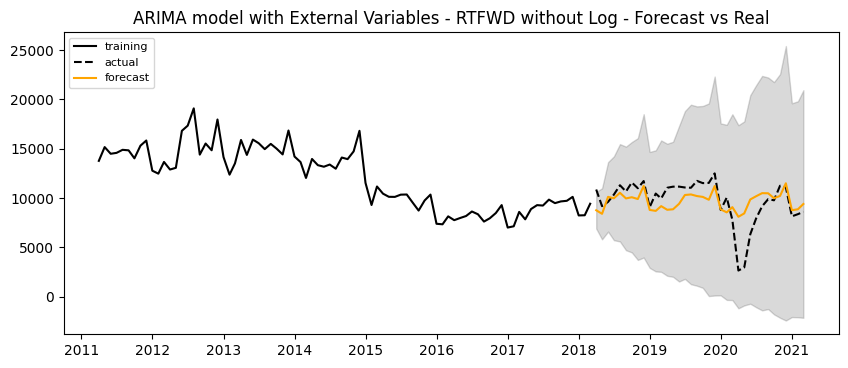

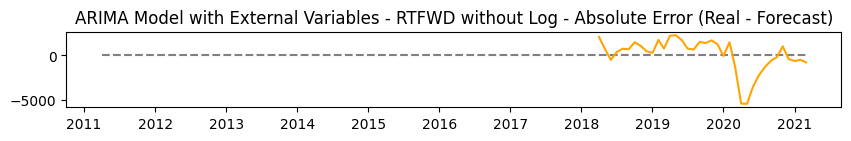

In [113]:
print('ARIMA model with Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_arima_with_external.values, forecast_arima_with_external.values), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_arima_with_external.values, forecast_arima_with_external.values), 3))
plot_forecast(forecast_arima_with_external, train_arima_with_external, test_arima_with_external, lower_arima_with_external.values, upper_arima_with_external.values, 'ARIMA model with External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_with_external, absolute_error_test_arima_with_external['RTFWD difference'], 'ARIMA Model with External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

ARIMA model with Ext. Var. - RTFWD with Log - R2:  -20.363  - MAPE:  1.0


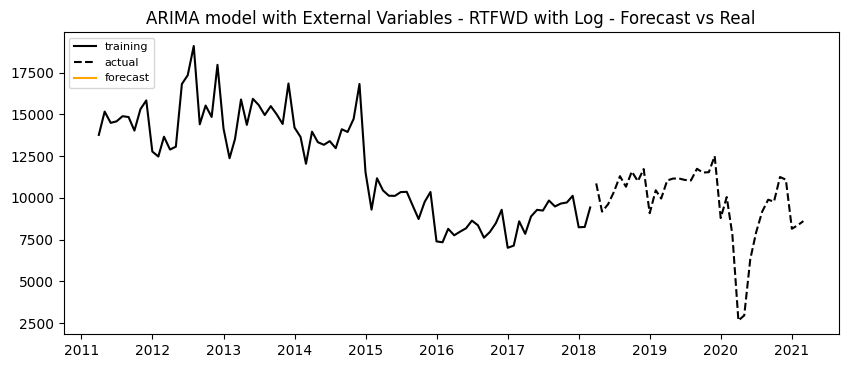

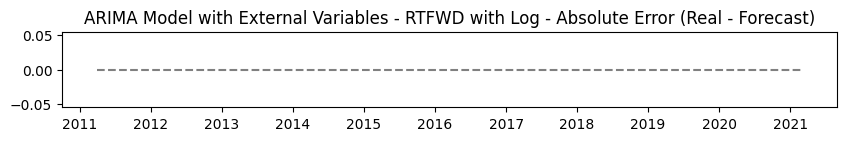

In [114]:
print('ARIMA model with Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_arima_with_external_log.values, np.nan_to_num(forecast_arima_with_external_log.values, posinf=0, neginf=0)), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_arima_with_external_log.values, np.nan_to_num(forecast_arima_with_external_log.values, posinf=0, neginf=0)), 3))
plot_forecast(forecast_arima_with_external_log, train_arima_with_external_log, test_arima_with_external_log, lower_arima_with_external_log.values, upper_arima_with_external_log.values, 'ARIMA model with External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_arima_with_external_log, absolute_error_test_arima_with_external_log['RTFWD difference'], 'ARIMA Model with External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

SVR Model w/o Ext. Var. - RTFWD w/o Log - Linear - R2:  0.413  - MAPE:  0.188


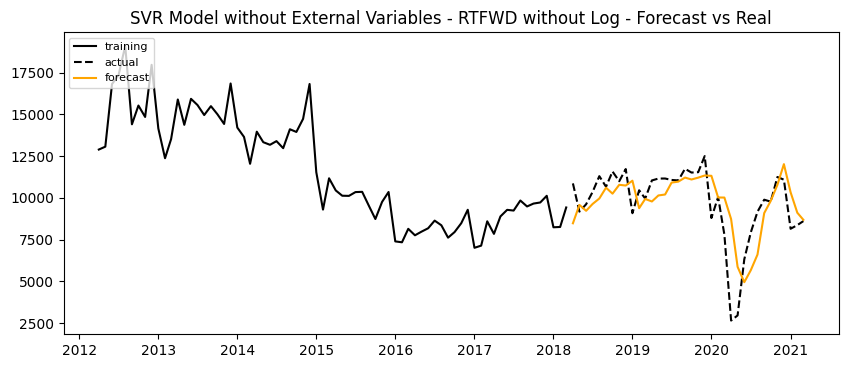

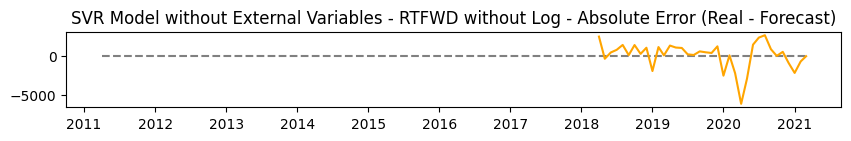

In [115]:
print('SVR Model w/o Ext. Var. - RTFWD w/o Log - Linear - R2: ', round(r2_score(test_svr_without_external, forecast_svr_without_external), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_without_external, forecast_svr_without_external), 3))
plot_forecast(forecast_svr_without_external, train_svr_without_external, test_svr_without_external, lower_svr_without_external, upper_svr_without_external, 'SVR Model without External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_without_external, absolute_error_test_svr_without_external['RTFWD difference'], 'SVR Model without External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

SVR Model w/o Ext. Var. - RTFWD with Log - Linear - R2:  0.426  - MAPE:  0.188


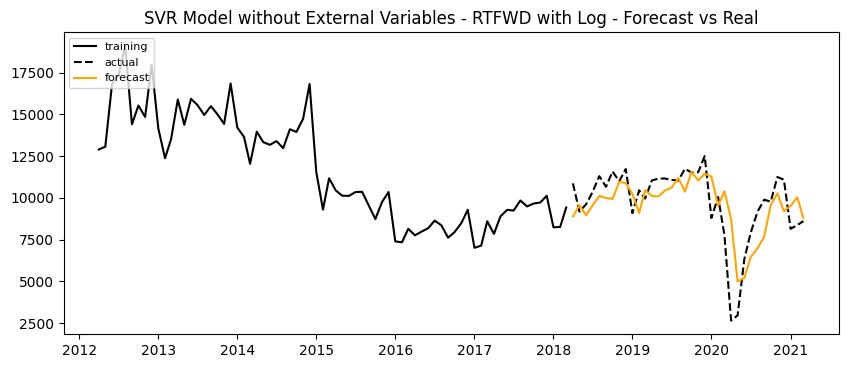

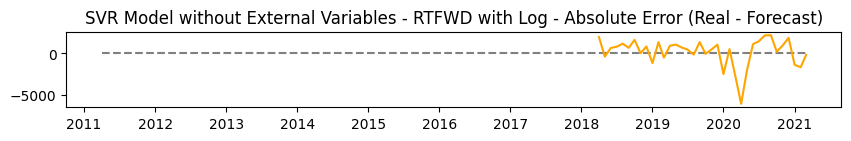

In [116]:
print('SVR Model w/o Ext. Var. - RTFWD with Log - Linear - R2: ', round(r2_score(test_svr_without_external_log, forecast_svr_without_external_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_without_external_log, forecast_svr_without_external_log), 3))
plot_forecast(forecast_svr_without_external_log, train_svr_without_external_log, test_svr_without_external_log, lower_svr_without_external_log, upper_svr_without_external_log, 'SVR Model without External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_without_external_log, absolute_error_test_svr_without_external_log['RTFWD difference'], 'SVR Model without External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

SVR Model with Ext. Var. - RTFWD w/o Log - R2:  0.413  - MAPE:  0.188


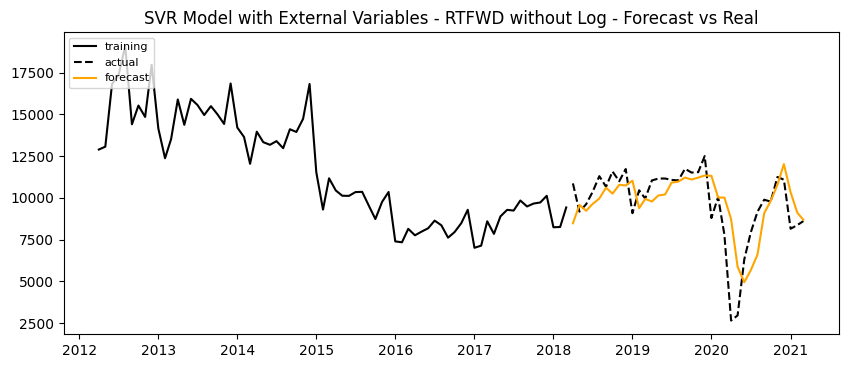

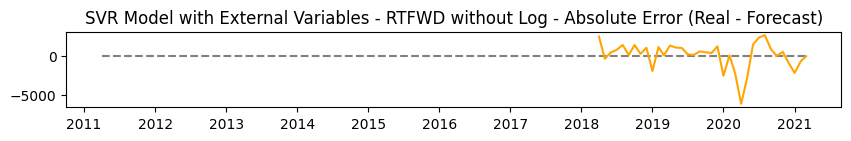

In [117]:
print('SVR Model with Ext. Var. - RTFWD w/o Log - R2: ', round(r2_score(test_svr_with_external, forecast_svr_with_external), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_with_external, forecast_svr_with_external), 3))
plot_forecast(forecast_svr_with_external, train_svr_with_external, test_svr_with_external, lower_svr_with_external, upper_svr_with_external, 'SVR Model with External Variables - RTFWD without Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_with_external, absolute_error_test_svr_with_external['RTFWD difference'], 'SVR Model with External Variables - RTFWD without Log - Absolute Error (Real - Forecast)')

SVR Model with Ext. Var. - RTFWD with Log - R2:  0.597  - MAPE:  0.132


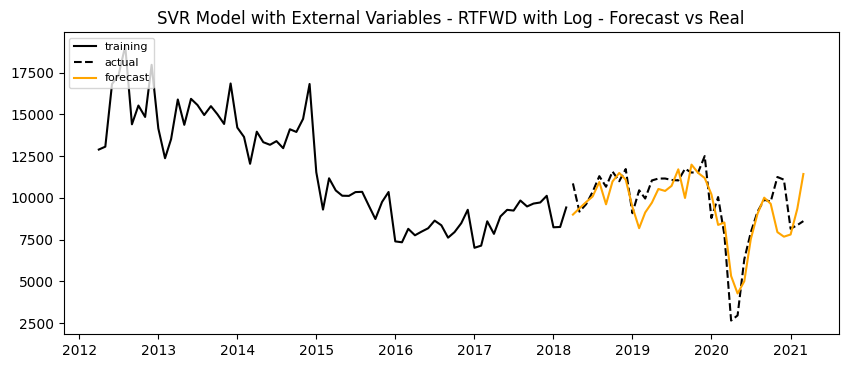

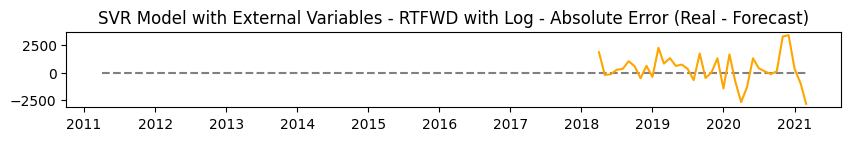

In [118]:
print('SVR Model with Ext. Var. - RTFWD with Log - R2: ', round(r2_score(test_svr_with_external_log, forecast_svr_with_external_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_svr_with_external_log, forecast_svr_with_external_log), 3))
plot_forecast(forecast_svr_with_external_log, train_svr_with_external_log, test_svr_with_external_log, lower_svr_with_external_log, upper_svr_with_external_log, 'SVR Model with External Variables - RTFWD with Log - Forecast vs Real'); plot_absolute_error(absolute_error_zero_svr_with_external_log, absolute_error_test_svr_with_external_log['RTFWD difference'], 'SVR Model with External Variables - RTFWD with Log - Absolute Error (Real - Forecast)')

In [119]:
print('PASSENGER CARS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_passenger_cars, forecast_best_model_passenger_cars), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_passenger_cars, forecast_best_model_passenger_cars), 3))
print('PASSENGER CARS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_passenger_cars_log, forecast_best_model_passenger_cars_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_passenger_cars_log, forecast_best_model_passenger_cars_log), 3))

PASSENGER CARS - Best Model (SVR w/o EV) w/o Log - R2:  0.45  - MAPE:  0.21
PASSENGER CARS - Best Model (SVR w/o EV) with Log - R2:  0.478  - MAPE:  0.177


In [120]:
print('LIGHT COMMERCIALS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_light_commercials, forecast_best_model_light_commercials), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_light_commercials, forecast_best_model_light_commercials), 3))
print('LIGHT COMMERCIALS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_light_commercials_log, forecast_best_model_light_commercials_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_light_commercials_log, forecast_best_model_light_commercials_log), 3))

LIGHT COMMERCIALS - Best Model (SVR w/o EV) w/o Log - R2:  0.294  - MAPE:  0.157
LIGHT COMMERCIALS - Best Model (SVR w/o EV) with Log - R2:  0.515  - MAPE:  0.127


In [121]:
print('TRUCKS - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_trucks, forecast_best_model_trucks), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_trucks, forecast_best_model_trucks), 3))
print('TRUCKS - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_trucks_log, forecast_best_model_trucks_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_trucks_log, forecast_best_model_trucks_log), 3))

TRUCKS - Best Model (SVR w/o EV) w/o Log - R2:  0.115  - MAPE:  0.114
TRUCKS - Best Model (SVR w/o EV) with Log - R2:  0.076  - MAPE:  0.122


In [122]:
print('BUSES - Best Model (SVR w/o EV) w/o Log - R2: ', round(r2_score(test_best_model_buses, forecast_best_model_buses), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_buses, forecast_best_model_buses), 3))
print('BUSES - Best Model (SVR w/o EV) with Log - R2: ', round(r2_score(test_best_model_buses_log, forecast_best_model_buses_log), 3), ' - MAPE: ', round(mean_absolute_percentage_error(test_best_model_buses_log, forecast_best_model_buses_log), 3))

BUSES - Best Model (SVR w/o EV) w/o Log - R2:  0.393  - MAPE:  0.181
BUSES - Best Model (SVR w/o EV) with Log - R2:  0.343  - MAPE:  0.21


## End